# Motion Capture Data Analysis - European Championship of Standstill 2022

EC2022 took place in collaboration with EARMA conference in Oslo, Norway May 5th-6th. 

This notebook is adjusted from the NM19 script located at https://github.com/fourMs/MICRO/tree/master/NM19.

This is a public facing version of the motion analysis script.

The displacement data is savgol filtered to clean the high frequency noise and then cut into the sections of the excerpts and silence.

I cut the hoppipolla and the every breaking wave to be the same length as the other excerpts to ensure that they can be compared equally and to see if this makes Hoppipolla a more appropriate low groove example because then it would avoid the build-up and emotional parts of the song. 

I also save full length versions of every breaking wave and hoppipolla for their comparison as well. 

# Setup
## Libraries
Installing and importing libraries for data processing, sound analysis, and visualization. 

### Motion files
c3d files were imported into MATLAB,  gaps were filled with the motion capture toolbox, and units converted from meters to millimeters, and the files were exported as .tsv to be able to import the data into Python. See the script named `convert_c3d_tsv.m`  for this procedure. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
import os
import glob
import pickle

In [2]:
from scipy import stats
import scipy.interpolate as interpolate
from scipy.stats import wilcoxon
from matplotlib.ticker import FormatStrFormatter

In [3]:
from scipy import signal
from scipy.signal import savgol_filter as savgol

In [4]:
os.chdir('C:/Users/danasw/OneDrive/Documents/PhD/Research/Standstill/Motion_Analysis/Python/')

## Read MoCap Data into Pandas Dataframe
Even though OptiTrack documentation suggests that the y-plane is superior/inferior or up/down, the z-plane is actually the superior/inferior plane and also where participant height can be estimated. The X-plane is medial/lateral or left/right. The y-planr is anterior/posterior or forwards/backwards.

In [5]:
#Reading TSV files generated from  OptiTrack generated c3d files from Matlab (one for each session of participants) from local drive

raw = {}
metadata = {}
markers = {}

path = 'C:/Users/danasw/OneDrive/Documents/PhD/Research/Standstill/Motion_Analysis/Experimental-Data/tsv/'  # use your path for the folder containing mocap files
ec_files = sorted(glob.glob(os.path.join(path, "*.tsv")))

i=1

for filename in ec_files:
    metadata[i] = pd.read_csv(filename, sep='\t', nrows=8, names = ['Metadata', 'Value'], encoding='utf-8', low_memory=False, na_values=np.nan) # nrows = 10 because the first 10 rows are metadata.
    markers[i] = pd.read_csv(filename, sep='\t', skiprows=9, nrows=1, header = None, encoding='utf-8', low_memory=False, na_values=np.nan) # nrows = 10 because the first 10 rows are metadata.
    markers[i].drop(markers[i].columns[0], axis=1, inplace=True)
    markers[i].drop(markers[i].columns[len(markers[i].columns)-1], axis=1, inplace=True)
    raw[i] = pd.read_csv(filename, sep='\t', skiprows=10, header = None, encoding='utf-8', low_memory=False, na_values=np.nan) # skip rows = 10 because the first 10 rows are metadata.
    raw[i].drop(raw[i].columns[len(raw[i].columns)-1], axis=1, inplace=True)
    i = i+1

In [6]:
# example
raw[20] #group T

0            1   ...          13           14
0      21.545526 -1294.615388  ... -310.654432  1794.551134
1      21.593997 -1294.737101  ... -310.488135  1794.543743
2      21.719884 -1294.835567  ... -310.291290  1794.547439
3      21.785222 -1294.951439  ... -310.144484  1794.559598
4      21.884812 -1295.058012  ... -309.996039  1794.552326
...          ...          ...  ...         ...          ...
59752  12.991413 -1342.521429  ... -289.398670  1794.806600
59753  12.990284 -1342.473149  ... -289.473653  1794.801950
59754  12.990440 -1342.422485  ... -289.545119  1794.807673
59755  12.960287 -1342.370868  ... -289.607435  1794.812560
59756  12.973338 -1342.319131  ... -289.658457  1794.817805

[59757 rows x 15 columns]

## Extract individual participants from groups and nest in dictionaries

In [7]:
ec22 = {}
    
num_groups = len(raw)

#iterate through groups
for g_id in range(1,num_groups+1): # for group ID
    ec22[g_id] = {}
    #iterate through participants
    num_pts = len(markers[g_id].columns)
    time = raw[g_id].index/120
    for pt in range(0, num_pts):
        pt_id = markers[g_id][pt+1][0] # extracts a string like Standstill:1
        pt_n = int(pt_id.split(':')[-1]) # extracts the number from it (including if it is single or double digits)
        df = raw[g_id].iloc[:, pt*3:pt*3+3]
        df.columns = ['X', 'Y', 'Z']
        df.insert(loc = 0, column = 'time_s', value = time)
        ec22[g_id][pt_n] = df

In [8]:
ec22[20]#data from group 20 = T, participants: 4,5,6,7,8.
# September 27th, 2023 - I learned through a spatial visualization that the markers wre labelled incorrectly in the c3d file. Therefore I updated the marker names in the tsv file such that it is 5,6,7,8, 9. 

{5:            time_s          X            Y            Z
 0        0.000000  21.545526 -1294.615388  1820.320487
 1        0.008333  21.593997 -1294.737101  1820.322156
 2        0.016667  21.719884 -1294.835567  1820.319653
 3        0.025000  21.785222 -1294.951439  1820.323229
 4        0.033333  21.884812 -1295.058012  1820.330739
 ...           ...        ...          ...          ...
 59752  497.933333  12.991413 -1342.521429  1818.319321
 59753  497.941667  12.990284 -1342.473149  1818.309307
 59754  497.950000  12.990440 -1342.422485  1818.311572
 59755  497.958333  12.960287 -1342.370868  1818.321466
 59756  497.966667  12.973338 -1342.319131  1818.315625
 
 [59757 rows x 4 columns],
 6:            time_s            X            Y            Z
 0        0.000000 -1019.391298 -1287.807107  1675.528765
 1        0.008333 -1019.323230 -1287.904501  1675.512433
 2        0.016667 -1019.293070 -1288.018107  1675.522089
 3        0.025000 -1019.187689 -1288.140893  1675.507188
 4 

In [9]:
ec22[20][7] #data from group 20 = T, participant 7

time_s           X           Y            Z
0        0.000000  976.052642 -174.231187  1768.847704
1        0.008333  976.045310 -174.232766  1768.859625
2        0.016667  976.046443 -174.248055  1768.850923
3        0.025000  976.059735 -174.246028  1768.849373
4        0.033333  976.048827 -174.254254  1768.837214
...           ...         ...         ...          ...
59752  497.933333  948.727190 -153.411448  1765.905976
59753  497.941667  948.707581 -153.412715  1765.898585
59754  497.950000  948.683381 -153.402120  1765.907049
59755  497.958333  948.659182 -153.398797  1765.900254
59756  497.966667  948.627591 -153.407544  1765.911102

[59757 rows x 4 columns]

## Verify that the participant number matches position 
Convert the next cell to code cell type to assess that the participant number matches their position in the room. 

#aa = plt.subplot(1, 3, 1)
for group in ec22:
    fig = plt.figure(figsize=(8,6))
    for pt in ec22[group]:
        print(pt)
        plt.plot(ec22[group][pt]['X'], ec22[group][pt]['Y'])
        plt.title('ML-AP (mm) Group '+str(group), fontsize=14) #plt.title('SI-AP (mm)', fontsize=14) # bird's eye view
        #plt.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        #plt.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('X Position (mm)', fontsize=11)
        plt.ylabel('Y Position (mm)', fontsize=11)

    #fig.suptitle('Marker position Group 10, Participant 2 (winner)', fontsize=16)

    fig.savefig(str("Birds_Eye/paths_group"+str(group)+".png"), bbox_inches='tight')

The front of the room is -2000 and the back of the room is 2000. Participants were positioned approximately 1m away from others.

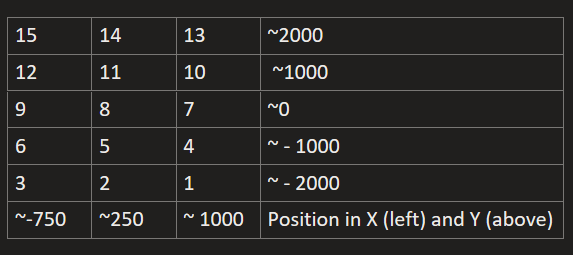

1
2
3
10


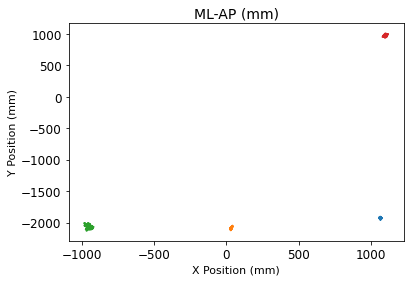

In [10]:
group = 4

for pt in ec22[group]:
    print(pt)
    plt.plot(ec22[group][pt]['X'], ec22[group][pt]['Y'])
    plt.title('ML-AP (mm)', fontsize=14) #plt.title('SI-AP (mm)', fontsize=14) # bird's eye view
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('X Position (mm)', fontsize=11)
    plt.ylabel('Y Position (mm)', fontsize=11)

# Exclusion
Notes taken during the competition were used to identify whether participants should be excluded.    

Some issues apart from drop-outs included:  
B5 and B6: double in optitrack, however Dana re-watched the c3d files in QTM and did not see any doubling in the mocap recording there so I am not sure why this was written down in the notes.  

C7, C8, C10 were unsalvageable and are not even included in the data. This is likely because a camera was bumped. 
C11 and C14 should be excluded because records from gap filling suggest that there were many missing frames (15000 = 125 seconds and 2500 = 20 seconds respectively). 

T7 flickered  
V4 had a flicker caused by a woman throwing her purse at a camera stand.   
Y7 coughed.   

Therefore I excluded all of group C and those who dropped out, but retained the group B participants and V4 and Y7 and relied on the exclusion criteria in R (1.5 x IQR) to take care of any problematic data.

## Exclude participants who dropped out
Participants were instructed that they would be excluded from the experiment if they dropped out and that they were free to do so at any time and to sit down in the position they were in if they so chose.  

H1 and H4 dropped out at 6:57   
Q6 stopped at ~5:35, started at ~ 6:15 and stopped again at 6:50    
R14 dropped out at 8:15  
T8 dropped out from coughing at 7:20  
W5 and W6 were laughing  

Letter group's corresponding group number:  
H: 8   
Q: 17   
R: 18   
T: 20   
W: 23  

In [11]:
# H1, H4, Q6, R14, T8, W5, W6
drop_outs = pd.DataFrame({'Group': [8,8,17,18,20,23,23], 'Participant': [1,4,6,14,8,5,6]})

for rows in drop_outs.index:
    group, participant = drop_outs.iloc[rows,:]
    del ec22[group][participant]


# Tidy data
## Shorten V4 recording to the frames that were captured
Because for some reason gap fill or another processing step caused an artefact to be introduced that made it look like there was a lot of motion when there wasn't.

Final frame: 59819

What is the duration of the experiment? It was 500 seconds. When shortening V4 it brings it down to 498 duration which means that it might be shorter in the last segment.

In [12]:
ec22[22][4] = ec22[22][4].iloc[0:59819]

## Calculate height
Save in a csv.

Take the first measure of Z dimension and that is a good approximation of height.

In [13]:
height_list = []
group_list = []
pt_list = []
for group, dict1 in ec22.items():
    for pt, dict2 in dict1.items():
        height = int((dict2.Z.iloc[0])/10)
        height_list.append(height)
        group_list.append(group)
        pt_list.append(pt)

In [14]:
df = pd.DataFrame(list(zip(group_list, pt_list, height_list)), columns = ['Group', 'Participant', 'Height'])
df.to_csv('Height.csv')

## Estimate sampling Frequency 

In [15]:
df_motion = ec22[1][7]

In [16]:
# estimate avg sampling rate
freq = int(round(1/ np.mean(np.diff(df_motion.time_s)), 3))
print('sr:', freq, 'Hz')

sr: 120 Hz


Min: 0.008333333333325754, Max: 0.008333333333382598, Mean: 0.008333333333333333


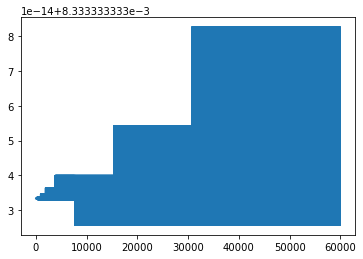

In [17]:
diff = np.diff(df_motion.time_s)
plt.plot(diff)
print('Min: ' + str(min(diff))+ ', Max: ' +str(max(diff))+ ', Mean: '+str(np.mean(diff)))

# Calculate variables for analysis (displacement, velocity, quantity of motion)

## Calculating displacement (change of position)

In [18]:
def displacement(position):

    displacement = (
        np.roll(position, -1, axis=0)
        - position)
    displacement = displacement.drop(displacement.index[len(displacement)-1])
    
    displacement.index =  position['time_s'][1:]
    
    return displacement


In [19]:
displacements = {}    

for groups in range(1,num_groups+1):
    displacements[groups] = {}
    
    for k,v in ec22[groups].items():
        displacements[groups][k] = displacement(ec22[groups][k])
        displacements[groups][k]['timestep_s'] = displacements[groups][k]['time_s']
        displacements[groups][k] = displacements[groups][k].drop(['time_s'], axis=1)
        

### Calculating norm of displacement

In [20]:
def disp_norm(displacement):
  
       
    dispnorm = np.sqrt(
         displacement.X ** 2 +
         displacement.Y ** 2 +
         displacement.Z ** 2
    )
    
    return pd.DataFrame({
        'Norm of Displacement': dispnorm,
    })

In [21]:
disp_norms = {}    

for groups in range(1,num_groups+1):
    disp_norms[groups] = {}
    
    for k,v in ec22[groups].items():
        disp_norms[groups][k] = disp_norm(displacements[groups][k])

### Distance travelled
Cumulative distance travelled

In [22]:
#Concatenating norm of displacement for all participants in each group
disp_norms_group = {}
for group_id in range (1,num_groups+1):
    disp_norms_group[group_id] = pd.concat(disp_norms[group_id],axis = 1)

## Filter the displacement data and re-calculate dispnorm

#### Savgol filter 
Filter the data to clean it from the jitter noise. 

The window size is a trade-off between retaining noise and rejecting purposeful movements. Given that the jittering is happening every other frame, and purposeful movements would probably still be visible, you might be able to reduce noise with a bigger window size. The window size needs to be an odd number to be symmetric around the central window. A window size of 13 would be very similar to a 10Hz low pass filter which should be sufficient to clean up the data. Indeed in a previous analysis we compared this to a 10 Hz low pass filter and this Savgol filter performed very similarly. 

The polynomial order controls the complexity of the polynomial. Lower order polynomials are commonly used. 

Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

In [23]:
displacements_savgol = {}
wl = 13 # this is ~1/10th of a second. 
po = 3 # polynomial order
for groups in range(1, num_groups+1):
    displacements_savgol[groups] = {}
    
    for k, v in displacements[groups].items():
        X =savgol(v.X, window_length = wl, polyorder = po, mode = "nearest")
        Y =savgol(v.Y, window_length = wl, polyorder = po, mode = "nearest")
        Z =savgol(v.Z, window_length = wl, polyorder = po, mode = "nearest")
        d = {"time_s": v.index, "X":X, "Y":Y, "Z":Z, "timestep_s" : v.timestep_s}
        df = pd.DataFrame(d)
        df.index = df.time_s
        df.drop(['time_s'], axis=1)
        
        displacements_savgol[groups][k]=df

##### Calculating norm of displacement

In [24]:
disp_norms_savgol = {}    

for groups in range(1,num_groups+1):
    disp_norms_savgol[groups] = {}
    
    for k,v in ec22[groups].items():
        disp_norms_savgol[groups][k] = disp_norm(displacements_savgol[groups][k])

##### Distance travelled
Cumulative distance travelled

In [25]:
#Concatenating norm of displacement for all participants in each group
disp_norms_group_savgol = {}
for group_id in range (1,num_groups+1):
    disp_norms_group_savgol[group_id] = pd.concat(disp_norms_savgol[group_id],axis = 1)

### Plot norm of displacement/cumulative distance travelled
Cell below converted to markdown to reduce memory usage.

for grp in range(1, 27):
    disp_norms_group[grp].cumsum().plot(figsize=(10,8), linewidth=2, fontsize=14) #Indicate group number to plot
    plt.xlabel('Time (s)', fontsize=14);
    plt.ylabel('Displacement (mm)', fontsize=14);
    plt.legend(loc='upper left', fontsize=16)
    plt.title('Distance travelled: Group'+str(grp), fontsize=16)
    plt.savefig('Post_Exclusion_Cumulative_Distance_Plots/Cum_Dist_Group'+str(grp)+'.png')

### Plotting the planar displacement
Position data
x: medial-lateral (ML) 
y: anterior-posterior (AP)
z: superior-inferior (SI)

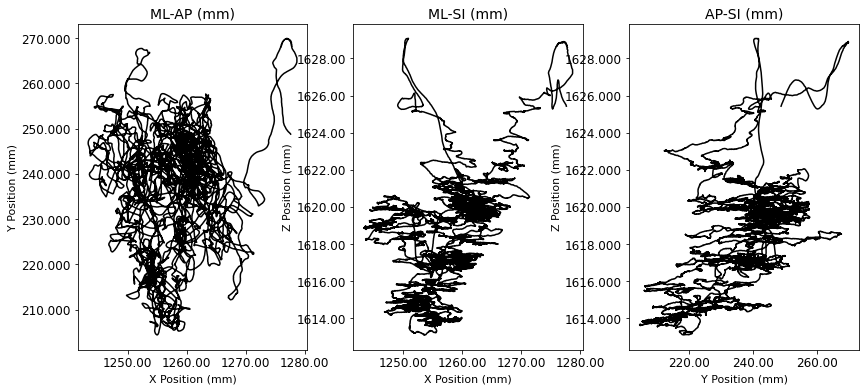

In [26]:
from matplotlib.ticker import FormatStrFormatter

group = 1
pt  = 7

fig = plt.figure(figsize=(14,6))
aa = plt.subplot(1, 3, 1)
plt.plot(ec22[group][pt]['X'], ec22[group][pt]['Y'], color='k')
plt.title('ML-AP (mm)', fontsize=14) #plt.title('SI-AP (mm)', fontsize=14)
aa.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
aa.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('X Position (mm)', fontsize=11)
plt.ylabel('Y Position (mm)', fontsize=11)

ab = plt.subplot(1, 3, 2)
plt.plot(ec22[group][pt]['X'], ec22[group][pt]['Z'], color='k')
plt.title('ML-SI (mm)', fontsize=14)
ab.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ab.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('X Position (mm)', fontsize=11)
plt.ylabel('Z Position (mm)', fontsize=11)

ac = plt.subplot(1, 3, 3)
plt.plot(ec22[group][pt]['Y'], ec22[group][pt]['Z'], color='k')
plt.title('AP-SI (mm)', fontsize=14)
ac.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ac.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Y Position (mm)', fontsize=11)
plt.ylabel('Z Position (mm)', fontsize=11)

#fig.suptitle('Marker position Group 10, Participant 2 (winner)', fontsize=16)

fig.savefig(str("paths_group"+str(group)+"_pt"+str(pt)+".png"), bbox_inches='tight')

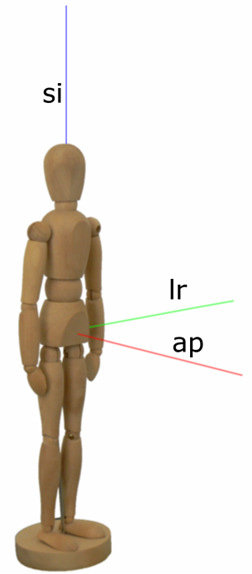

ML: Medial lateral (left right) = x  
AP: anterior posterior  = y  
SI: superior inferior  = z  

## Calculating velocity in X, Y, and Z directions
Defining and running functions to calculate velocity

In [27]:
def x_vel(displacement):
    
    #displacement = displacement.drop(displacement.index)
    
    vel = np.sqrt(
         displacement.X ** 2) /  displacement['timestep_s']
    
    return pd.DataFrame({
        'Vel X': vel,
    })

In [28]:
def y_vel(displacement):
   
    #displacement = displacement.drop(displacement.index)
    
    vel = np.sqrt(
         displacement.Y ** 2) /  displacement['timestep_s']
    
    return pd.DataFrame({
        'Vel Y': vel,
    })

In [29]:
def z_vel(displacement):
    
    #displacement = displacement.drop(displacement.index)
    
    vel = np.sqrt(
         displacement.Z ** 2) /  displacement['timestep_s']
    
    return pd.DataFrame({
        'Vel Z': vel,
    })

In [30]:
velx = {} # Lateral (ML)
vely = {} # anterior-posterior (AP)
velz = {} # vertical (SI)

for groups in range(1,num_groups+1):
    velx[groups] = {}
    vely[groups] = {}
    velz[groups] = {}
    
    for k,v in ec22[groups].items():
        velx[groups][k] = x_vel(displacements[groups][k])
        vely[groups][k] = y_vel(displacements[groups][k])
        velz[groups][k] = z_vel(displacements[groups][k])

In [31]:
velx_sg = {} # Lateral (ML)
vely_sg = {} # anterior-posterior (AP)
velz_sg = {} # vertical (SI)

for groups in range(1,num_groups+1):
    velx_sg[groups] = {}
    vely_sg[groups] = {}
    velz_sg[groups] = {}
    
    for k,v in ec22[groups].items():
        velx_sg[groups][k] = x_vel(displacements_savgol[groups][k])
        vely_sg[groups][k] = y_vel(displacements_savgol[groups][k])
        velz_sg[groups][k] = z_vel(displacements_savgol[groups][k])

In [32]:
group = 25
pt = 8
velx[group][pt] #velocity in the ML direction for participant pt

Vel X
time_s             
0.008333    1.75776
0.016667    1.81044
0.025000    0.48816
0.033333    3.19368
0.041667    0.66432
...             ...
500.358333  2.70816
500.366667  1.84896
500.375000  1.96920
500.383333  0.90828
500.391667  1.42776

[60047 rows x 1 columns]

### Calculating norm of velocity (QoM)

In [33]:
def velocity_norm(displacement):
    
    #displacement = displacement.drop(displacement.index)
    
    vel = np.sqrt(
         displacement.X ** 2 +
         displacement.Y ** 2 +
         displacement.Z ** 2
    ) /  displacement['timestep_s']
    
    return pd.DataFrame({
        'Velocity': vel,
    })
       

In [34]:
velocities = {}    

for groups in range(1,num_groups+1):
    velocities[groups] = {}
    
    for k,v in ec22[groups].items():
        velocities[groups][k] = velocity_norm(displacements[groups][k])

In [35]:
velocities_savgol = {}    

for groups in range(1,num_groups+1):
    velocities_savgol[groups] = {}
    
    for k,v in ec22[groups].items():
        velocities_savgol[groups][k] = velocity_norm(displacements_savgol[groups][k])

In [36]:
velocities[25][8] #displaying velocity for group 10, participant 2

Velocity
time_s              
0.008333    2.874943
0.016667    3.101691
0.025000    1.962208
0.033333    3.419861
0.041667    1.443459
...              ...
500.358333  2.941469
500.366667  3.252811
500.375000  2.605269
500.383333  1.605374
500.391667  2.696676

[60047 rows x 1 columns]

In [37]:
#Concatenating cleaned velocities for all participants in each group
vels_group = {}
velsx_group = {}
velsy_group = {}
velsz_group = {}

for group_id in range(1,num_groups+1):
    vels_group[group_id] = pd.concat(velocities[group_id],axis = 1)
    velsx_group[group_id] = pd.concat(velx[group_id], axis = 1)
    velsy_group[group_id] = pd.concat(vely[group_id], axis = 1)
    velsz_group[group_id] = pd.concat(velz[group_id], axis = 1)
    
    ID_group = list(k for k,v in ec22[group_id].items())
    
    vels_group[group_id].columns = ID_group
    velsx_group[group_id].columns = ID_group
    velsy_group[group_id].columns = ID_group
    velsz_group[group_id].columns = ID_group

In [38]:
#Concatenating cleaned velocities for all participants in each group
vels_group_sg = {}
velsx_group_sg = {}
velsy_group_sg = {}
velsz_group_sg = {}

for group_id in range(1,num_groups+1):
    vels_group_sg[group_id] = pd.concat(velocities_savgol[group_id],axis = 1)
    velsx_group_sg[group_id] = pd.concat(velx_sg[group_id], axis = 1)
    velsy_group_sg[group_id] = pd.concat(vely_sg[group_id], axis = 1)
    velsz_group_sg[group_id] = pd.concat(velz_sg[group_id], axis = 1)
    
    ID_group = list(k for k,v in ec22[group_id].items())
    
    vels_group_sg[group_id].columns = ID_group
    velsx_group_sg[group_id].columns = ID_group
    velsy_group_sg[group_id].columns = ID_group
    velsz_group_sg[group_id].columns = ID_group

In [39]:
velsx_group[25]

4        5         6        7        8        9
time_s                                                           
0.008333    2.44620  1.59948   5.87940  3.50484  1.75776  2.88252
0.016667    0.31476  0.91992   0.84408  1.74516  1.81044  1.15872
0.025000    2.34600  2.95764   4.12704  1.61652  0.48816  0.72960
0.033333    1.35900  2.91552   3.36876  2.23152  3.19368  3.89088
0.041667    4.59192  2.93880   2.14584  1.44492  0.66432  1.60944
...             ...      ...       ...      ...      ...      ...
500.358333  1.67364  0.20112   9.87768  3.97680  2.70816  1.11588
500.366667  2.84676  3.57180   4.63488  3.33312  1.84896  0.93696
500.375000  0.28608  2.67504  12.76740  2.70360  1.96920  2.76096
500.383333  2.05992  2.40144   5.47164  4.39176  0.90828  1.72380
500.391667  0.34332  0.07056   8.33280  2.98968  1.42776  1.50924

[60047 rows x 6 columns]

C:\Users\danasw\AppData\Local\Temp\ipykernel_8432\2499829725.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figbox, axbox = plt.subplots() # Dongho suggested that maybe the ;arge plots are slowing down Spyder


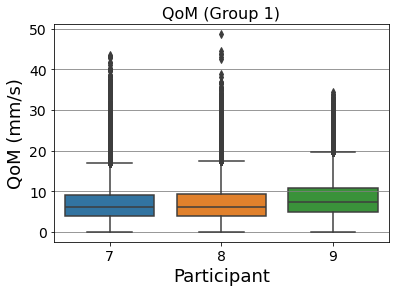

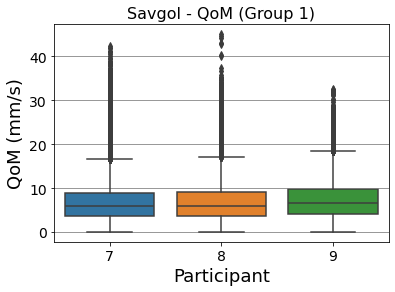

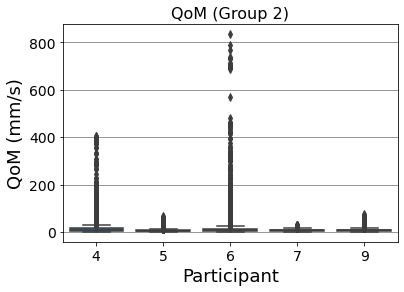

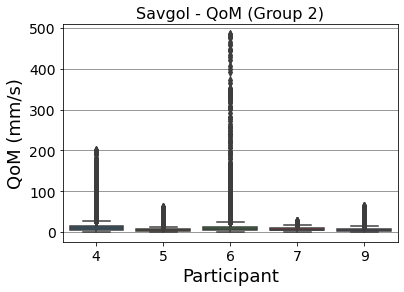

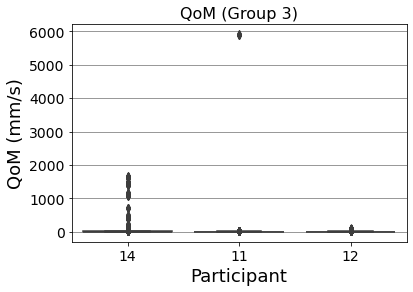

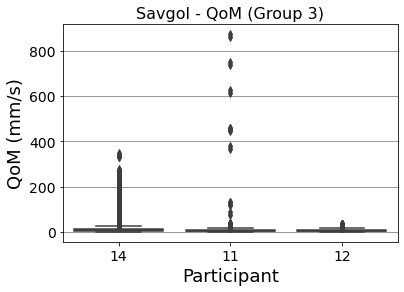

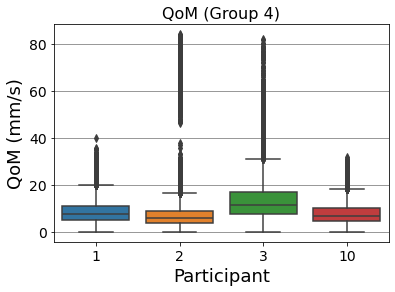

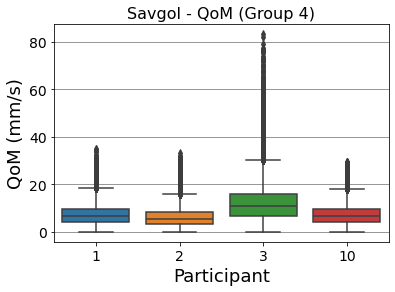

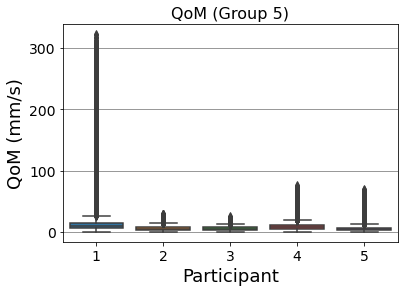

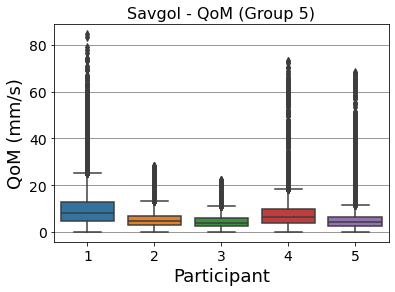

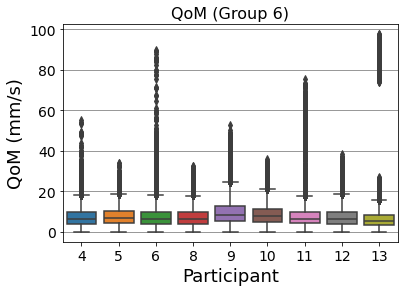

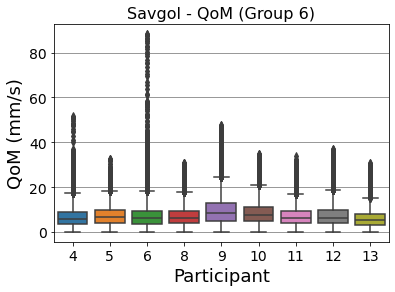

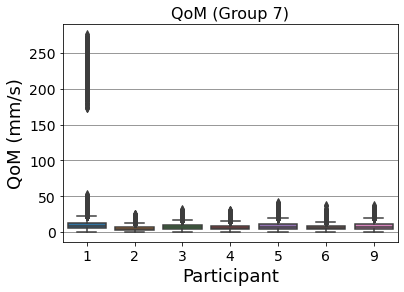

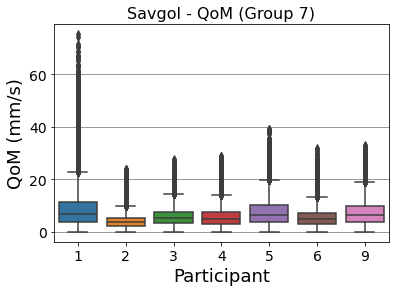

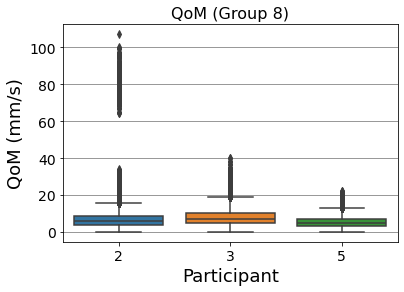

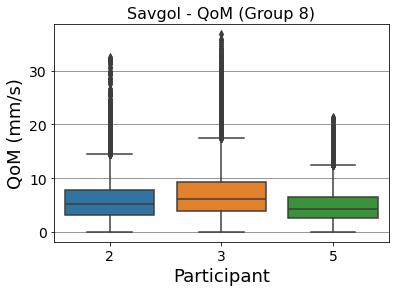

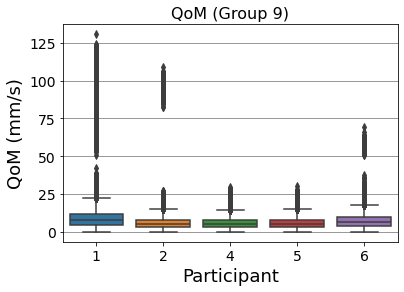

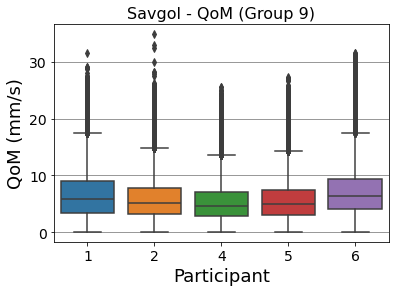

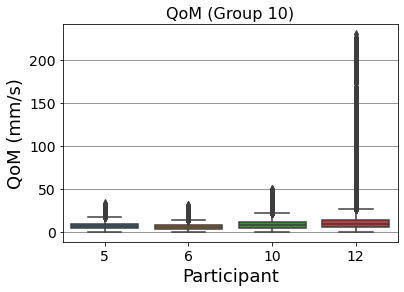

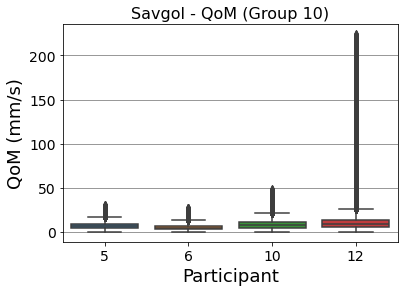

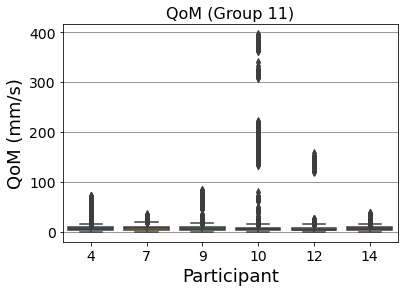

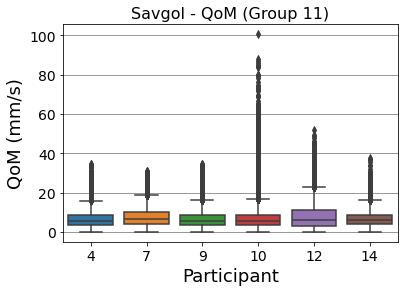

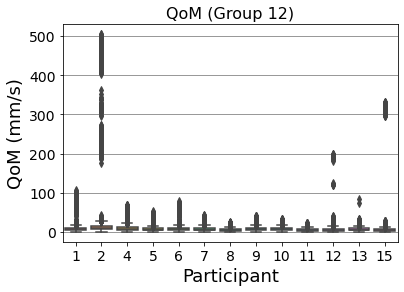

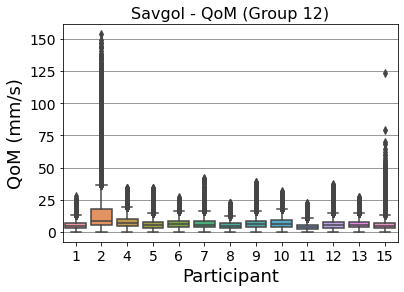

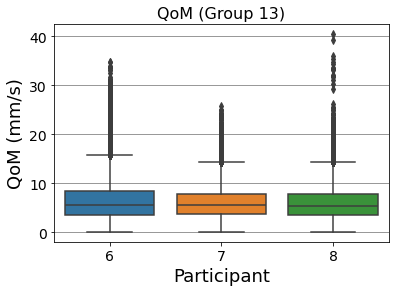

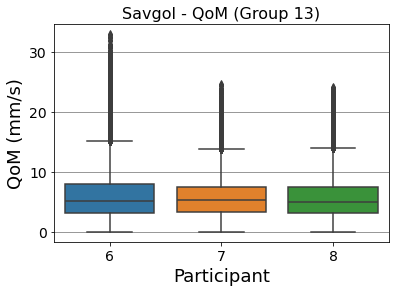

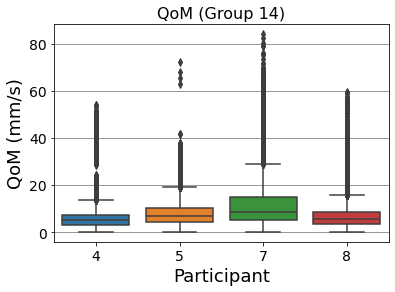

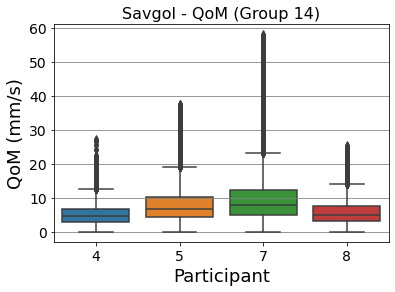

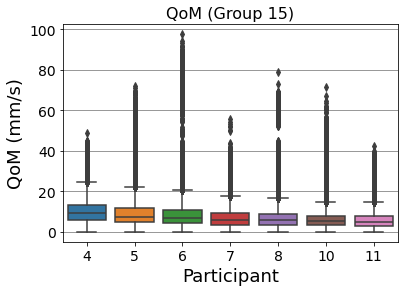

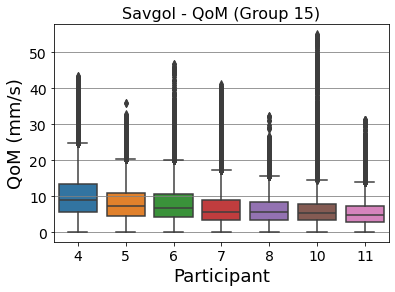

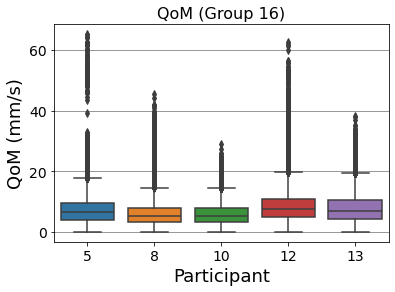

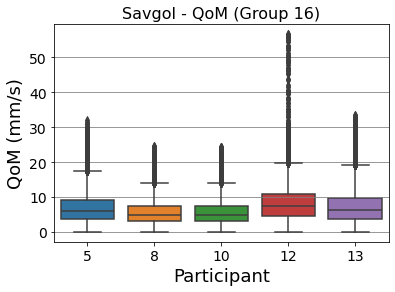

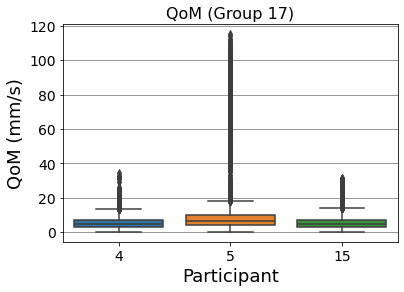

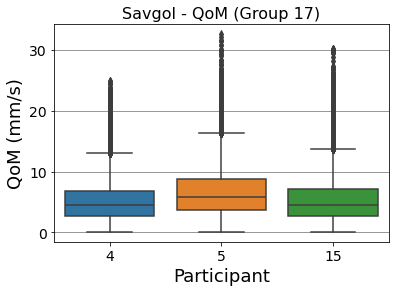

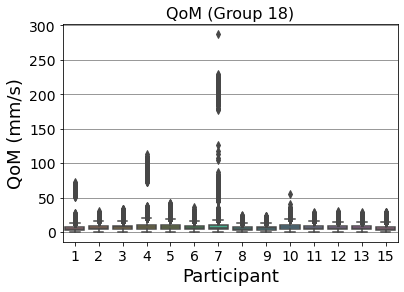

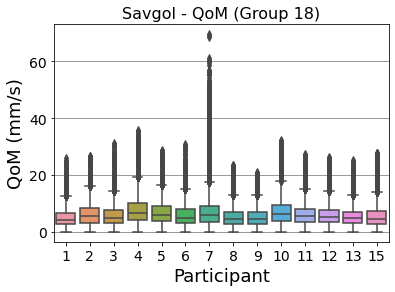

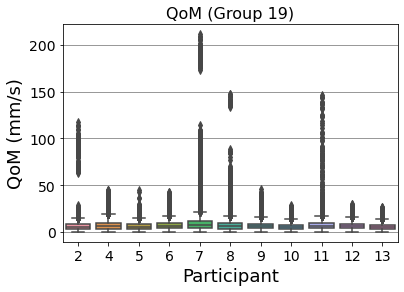

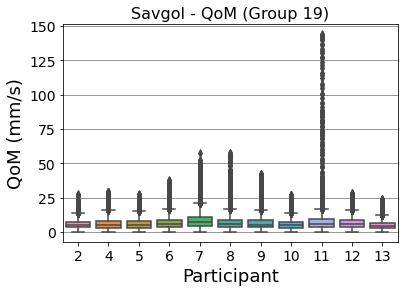

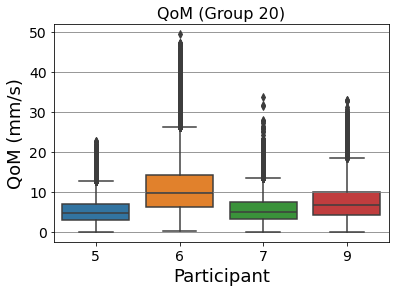

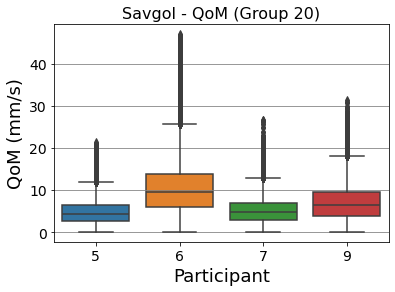

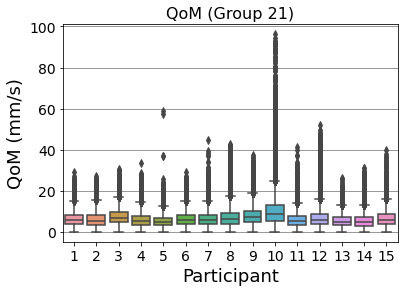

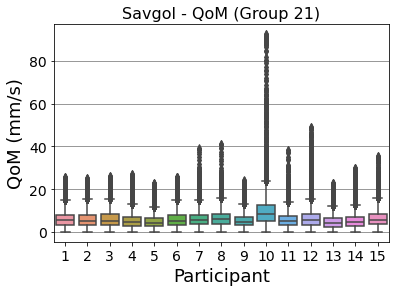

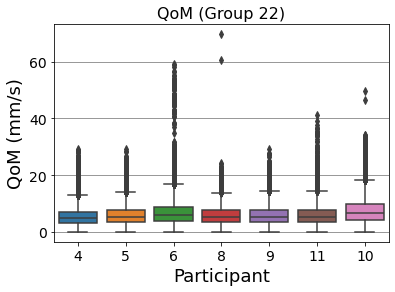

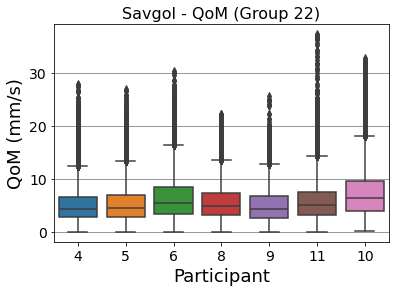

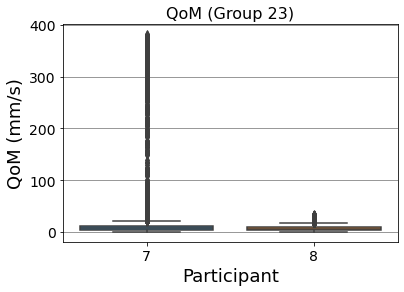

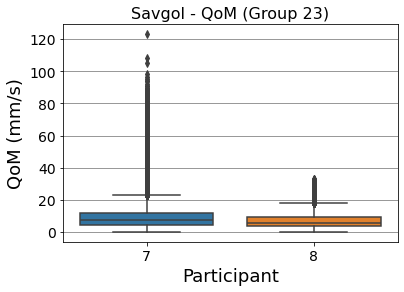

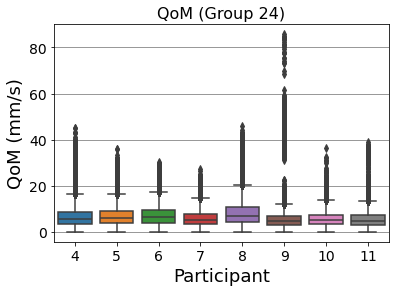

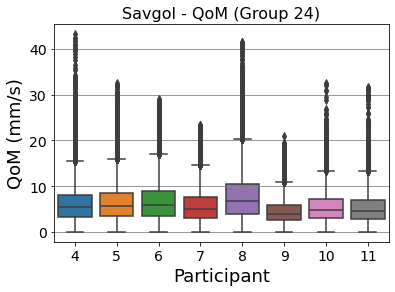

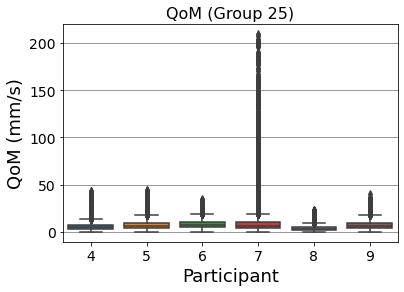

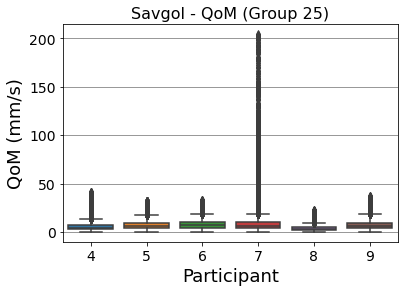

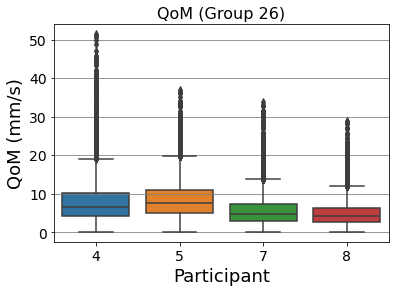

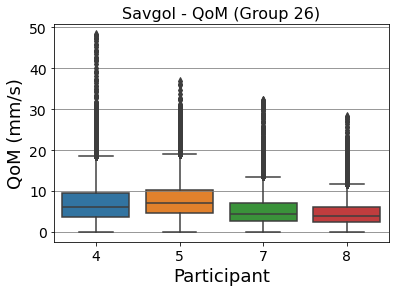

In [40]:
#Box plot of QoM
for grp in range(1, 27):
    #figbox, axbox = plt.subplots(figsize=(12,7)) # Dongho suggested that maybe the ;arge plots are slowing down Spyder
    figbox, axbox = plt.subplots() # Dongho suggested that maybe the ;arge plots are slowing down Spyder
    qombox = seaborn.boxplot(ax=axbox, data=vels_group[grp], width=0.8)
    axbox.set_facecolor("white")
    axbox.yaxis.grid(color='gray')
    qombox.set_xlabel("Participant",fontsize=18)
    qombox.set_ylabel("QoM (mm/s)",fontsize=18)
    qombox.tick_params(labelsize=14)
    qombox.axes.set_title("QoM (Group "+str(grp)+")", fontsize=16)
    #plt.savefig("Post_Exclusion_QoM_Boxplots/QoM_Boxplot_Group"+str(grp)+".png")

#figbox, axbox = plt.subplots(figsize=(12,7)) # Dongho suggested that maybe the ;arge plots are slowing down Spyder
    figbox, axbox = plt.subplots() # Dongho suggested that maybe the ;arge plots are slowing down Spyder
    qombox = seaborn.boxplot(ax=axbox, data=vels_group_sg[grp], width=0.8)
    axbox.set_facecolor("white")
    axbox.yaxis.grid(color='gray')
    qombox.set_xlabel("Participant",fontsize=18)
    qombox.set_ylabel("QoM (mm/s)",fontsize=18)
    qombox.tick_params(labelsize=14)
    qombox.axes.set_title("Savgol - QoM (Group "+str(grp)+")", fontsize=16)
    #plt.savefig("Post_Exclusion_QoM_Boxplots/QoM_Boxplot_Group"+str(grp)+".png")

These plots indicate that the average is very similar between the QoM of the raw and filtered data and that the outliers are what are being brought down to a more reasonable level. This is a good indication that this kind of filtering is effective.

### Smoothing velocity
Calculate the envelope of the velocity using a rolling average. (Later, QoM smooth is calculated/inherited from this data). 
Do this for visualization purposes.

240 samples = 2 seconds. 

In [232]:
#Smoothing the velocity profile for all participants (envelope)
## 2 seconds window rolling average
velenv = {}    
velenvx = {}
velenvy = {}
velenvz = {}

for groups in range(1,num_groups+1):
    velenv[groups] = {}
    velenvx[groups] = {}
    velenvy[groups] = {}
    velenvz[groups] = {}
    
    for k,v in ec22[groups].items():
        velenv[groups][k] = vels_group[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()
        velenvx[groups][k] = velsx_group[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()
        velenvy[groups][k] = velsy_group[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()
        velenvz[groups][k] = velsz_group[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()

In [233]:
#Concatenating smoothed velocity for all participants in each group
vel_env_group = {}
vel_envx_group = {}
vel_envy_group = {}
vel_envz_group = {}

for group_id in range(1,num_groups+1):
    vel_env_group[group_id] = pd.concat(velenv[group_id], axis = 1)
    vel_envx_group[group_id] = pd.concat(velenvx[group_id], axis = 1)
    vel_envy_group[group_id] = pd.concat(velenvy[group_id], axis = 1)
    vel_envz_group[group_id] = pd.concat(velenvz[group_id], axis = 1)

In [234]:
#Smoothing the velocity profile for all participants (envelope)
velenvSG = {}    
velenvxSG = {}
velenvySG = {}
velenvzSG = {}

for groups in range(1,num_groups+1):
    velenvSG[groups] = {}
    velenvxSG[groups] = {}
    velenvySG[groups] = {}
    velenvzSG[groups] = {}
    
    
    for k,v in ec22[groups].items():

        velenvSG[groups][k] = vels_group_sg[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()
        
        velenvxSG[groups][k] = velsx_group_sg[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()
        velenvySG[groups][k] = velsy_group_sg[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()
        velenvzSG[groups][k] = velsz_group_sg[groups][k].rolling(240,center=True,win_type='boxcar',min_periods=1).mean()

In [235]:
#Concatenating smoothed velocity for all participants in each group
vel_env_groupSG = {}
vel_envx_groupSG = {}
vel_envy_groupSG = {}
vel_envz_groupSG = {}

for group_id in range(1,num_groups+1):
    vel_env_groupSG[group_id] = pd.concat(velenvSG[group_id], axis = 1)
    vel_envx_groupSG[group_id] = pd.concat(velenvxSG[group_id], axis = 1)
    vel_envy_groupSG[group_id] = pd.concat(velenvySG[group_id], axis = 1)
    vel_envz_groupSG[group_id] = pd.concat(velenvzSG[group_id], axis = 1)

In [236]:
vel_envx_group[1]

7          8         9
time_s                                   
0.008333    4.414437  12.092114  2.458217
0.016667    4.414013  12.025341  2.446827
0.025000    4.537181  11.940374  2.460482
0.033333    4.577169  11.885138  2.467809
0.041667    4.583633  11.820005  2.485977
...              ...        ...       ...
499.475000  2.880136   2.563967  6.156636
499.483333  2.871984   2.539422  6.184137
499.491667  2.886145   2.492845  6.190860
499.500000  2.884592   2.463563  6.176704
499.508333  2.890935   2.424455  6.148422

[59941 rows x 3 columns]

Text(0.5, 1.0, 'Velocity (participant 25_8 (winner))')

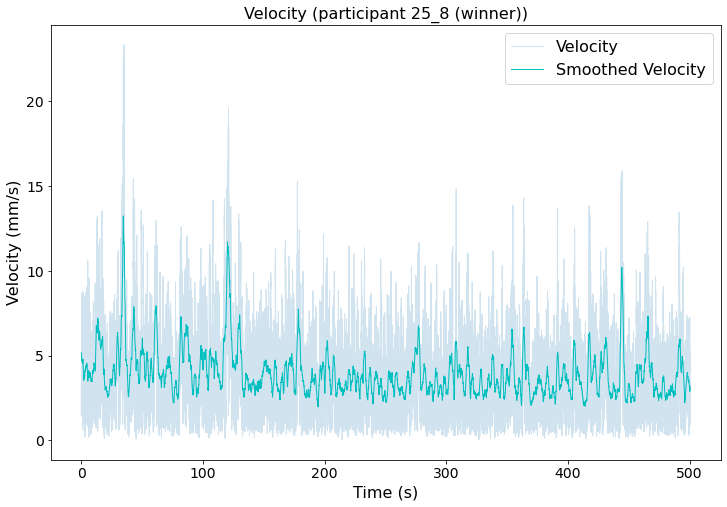

In [237]:
# Raw and smooth velocity plot for one participant
group = 25
pt = 8

fig, ax = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(12)
ax.set_facecolor("white")
ax.plot(vels_group[group][pt], lw=1, label='Velocity', alpha=0.2)
ax.plot(velenv[group][pt], lw=1, label='Smoothed Velocity', color='c')
plt.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc='upper right', fontsize=16)
plt.xlabel('Time (s)', fontsize=16);
plt.ylabel('Velocity (mm/s)', fontsize=16);
plt.title('Velocity (participant 25_8 (winner))', fontsize=16)

Text(0.5, 1.0, 'Velocity (participant 25_8 (winner))')

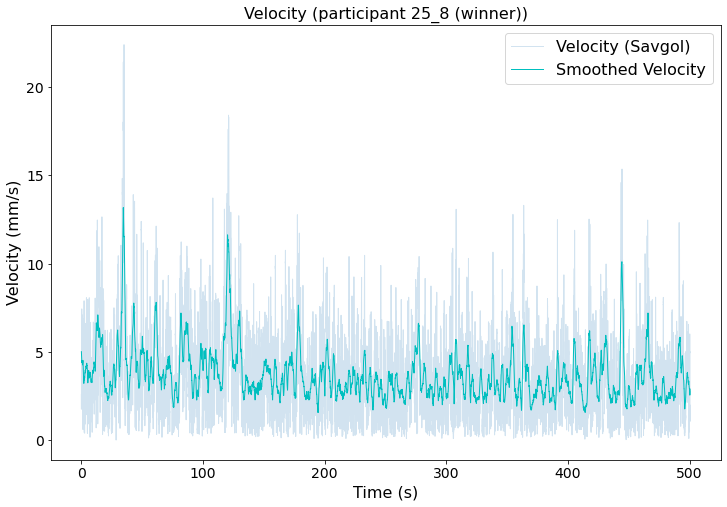

In [238]:
# Savgol Filtered and smooth velocity plot for one participant
group = 25
pt = 8

fig, ax = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(12)
ax.set_facecolor("white")
ax.plot(vels_group_sg[group][pt], lw=1, label='Velocity (Savgol)', alpha=0.2)
ax.plot(velenvSG[group][pt], lw=1, label='Smoothed Velocity', color='c')
plt.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc='upper right', fontsize=16)
plt.xlabel('Time (s)', fontsize=16);
plt.ylabel('Velocity (mm/s)', fontsize=16);
plt.title('Velocity (participant 25_8 (winner))', fontsize=16)

Text(0.5, 1.0, 'Velocities from all participants in Group 25')

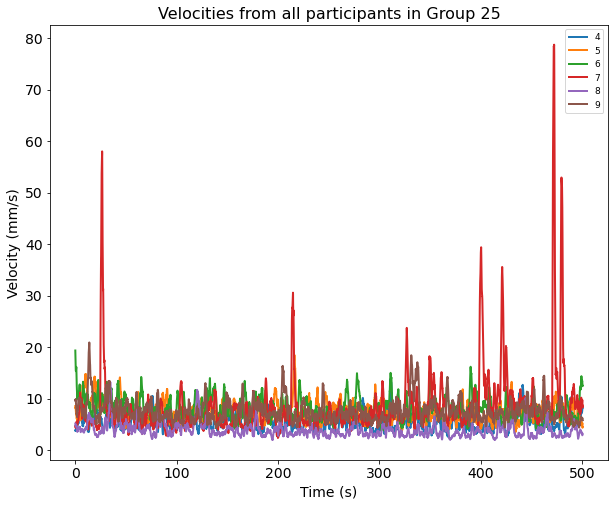

In [239]:
#Plotting all smoothed velocities for one group
ax1 = vel_env_group[25].plot(figsize=(10,8), linewidth=2, fontsize=14)
ax1.set_facecolor("white")
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Velocity (mm/s)', fontsize=14);
plt.legend(loc='upper right', fontsize=9)
plt.title('Velocities from all participants in Group 25', fontsize=16)

Text(0.5, 1.0, 'Velocities from all participants in Group 25')

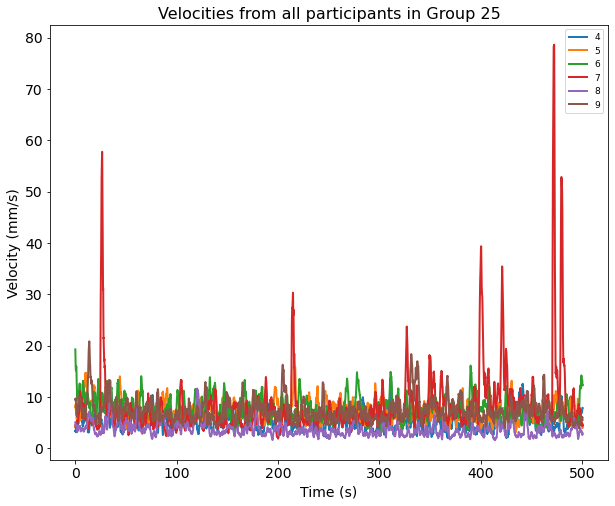

In [240]:
#Plotting all smoothed velocities for one group
ax1 = vel_env_groupSG[25].plot(figsize=(10,8), linewidth=2, fontsize=14)
ax1.set_facecolor("white")
plt.xlabel('Time (s)', fontsize=14);
plt.ylabel('Velocity (mm/s)', fontsize=14);
plt.legend(loc='upper right', fontsize=9)
plt.title('Velocities from all participants in Group 25', fontsize=16)

Code below converted to markdown to reduce the memory usage when executing code

C:\Users\danasw\AppData\Local\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


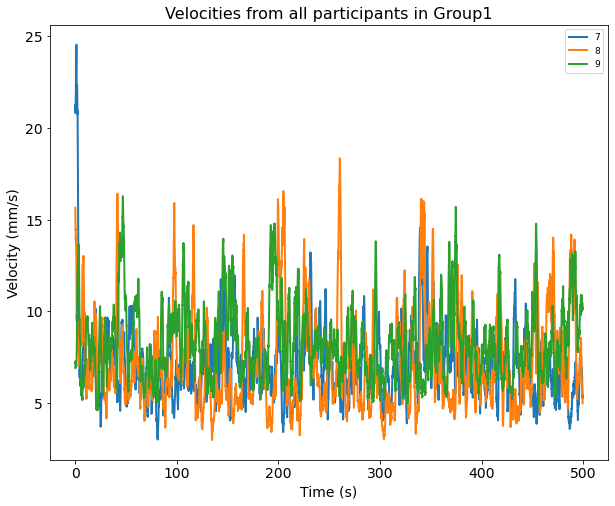

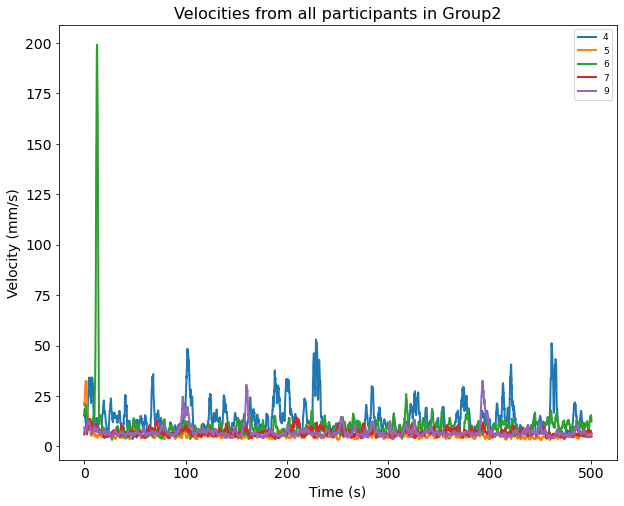

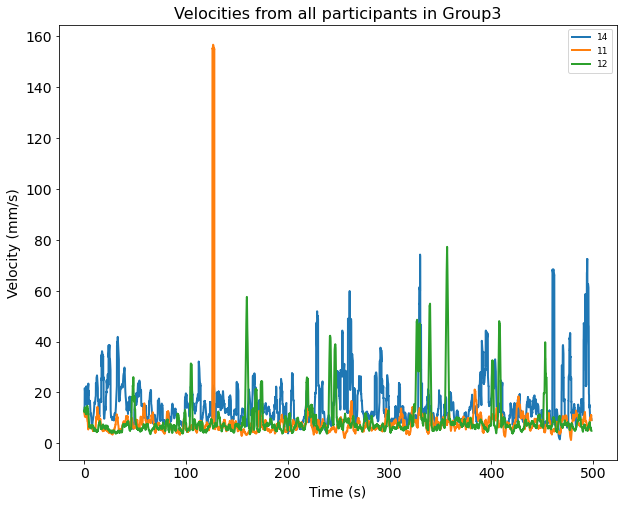

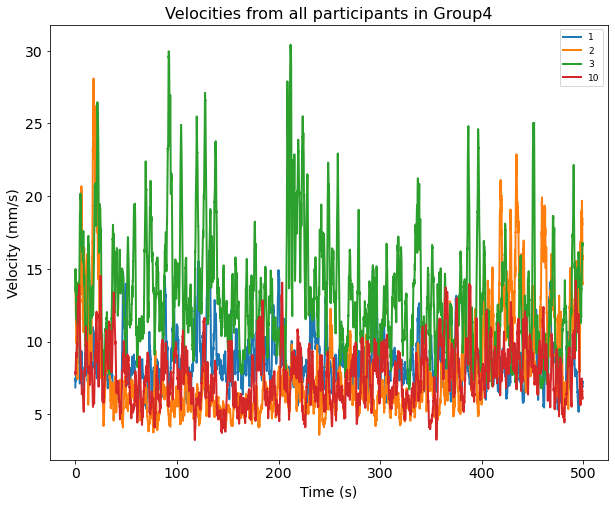

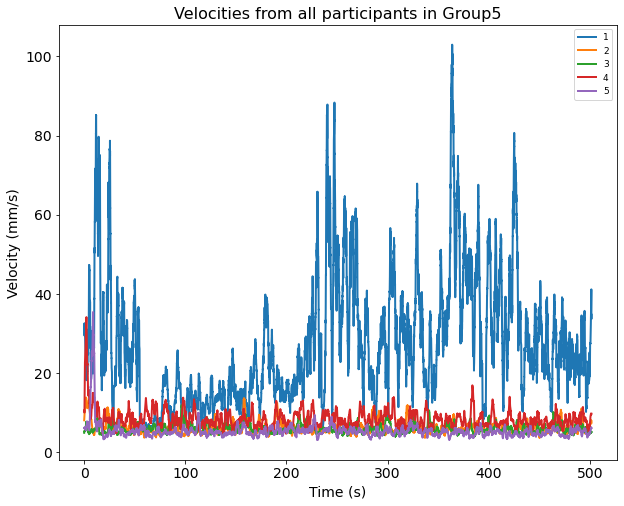

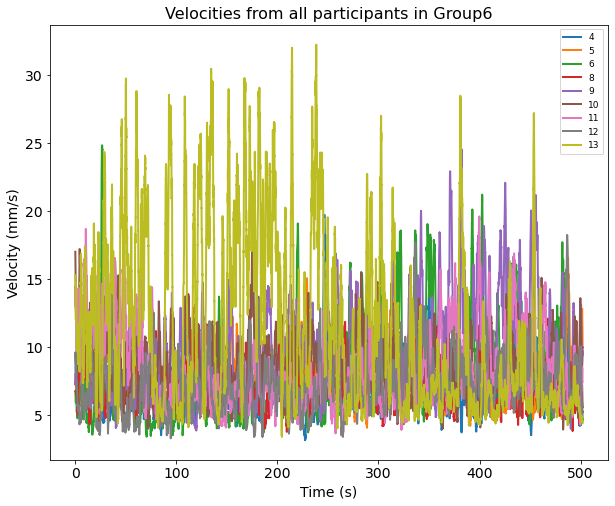

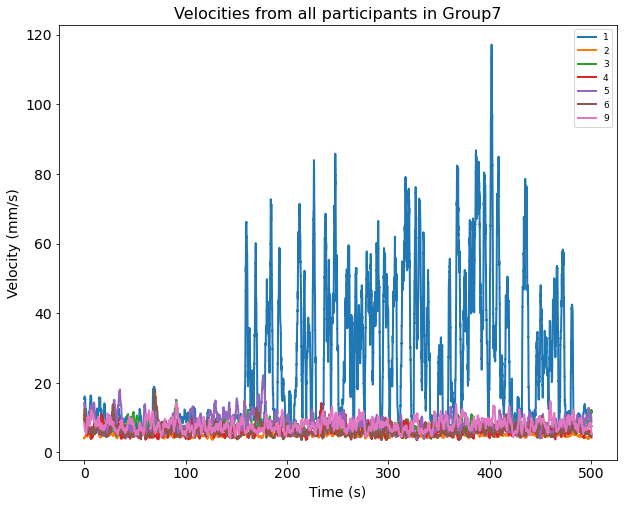

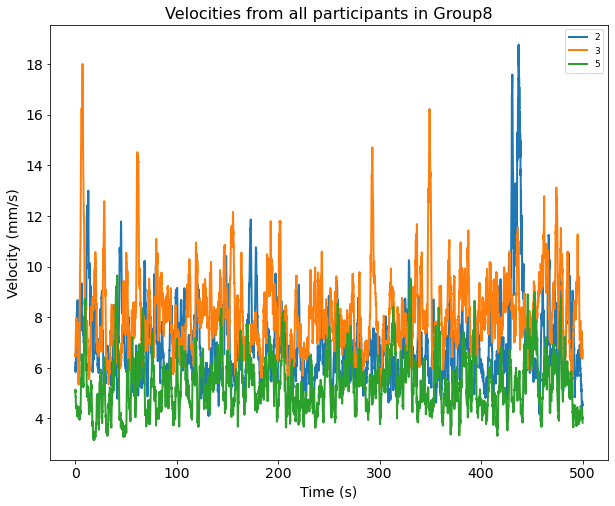

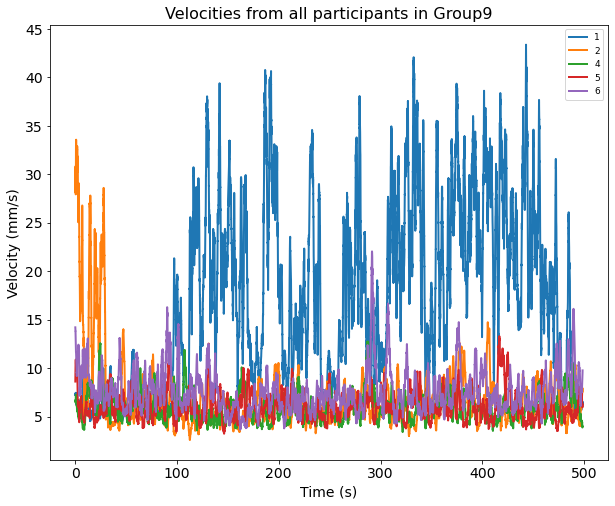

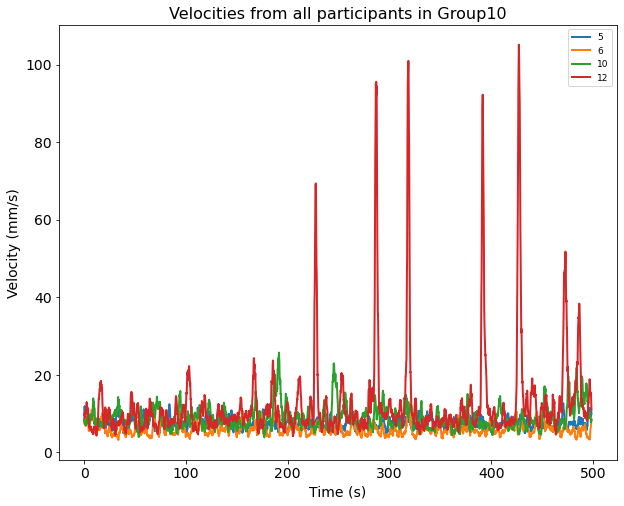

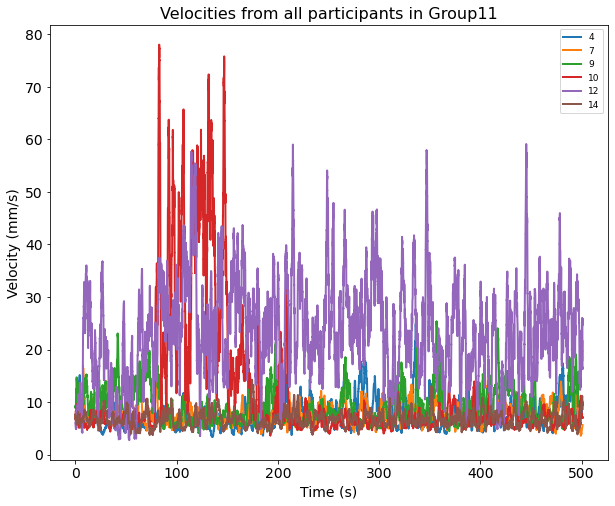

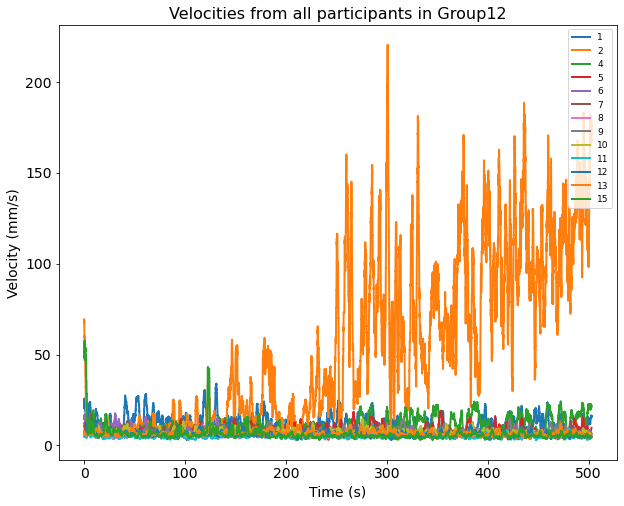

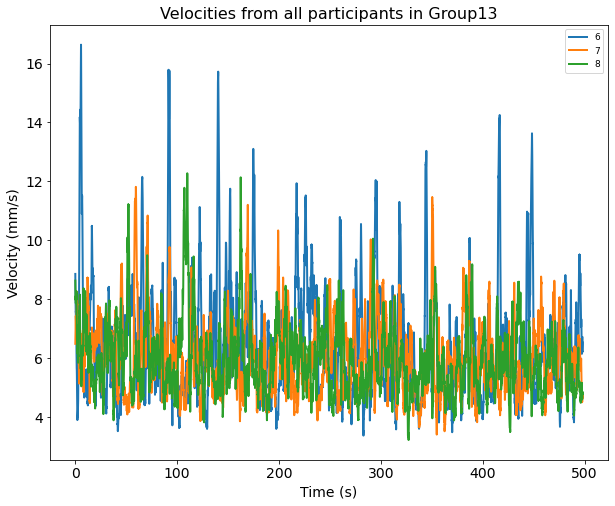

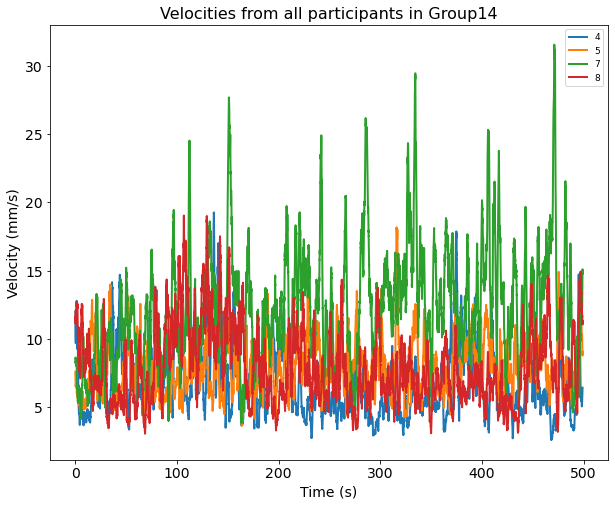

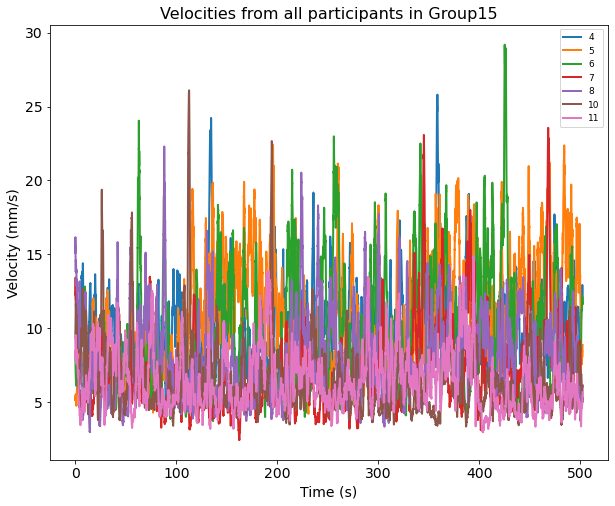

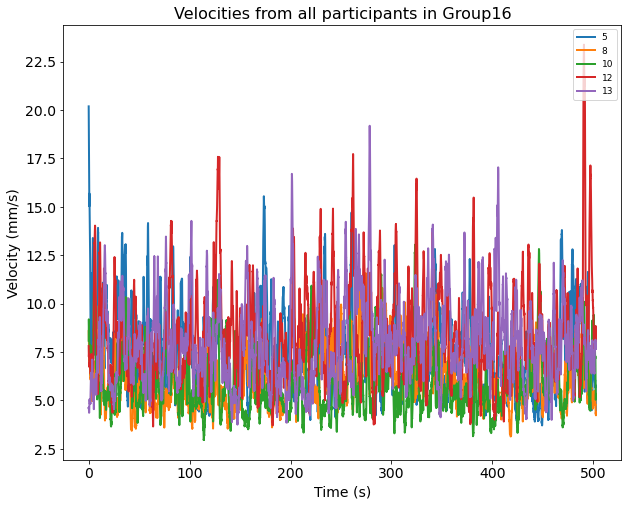

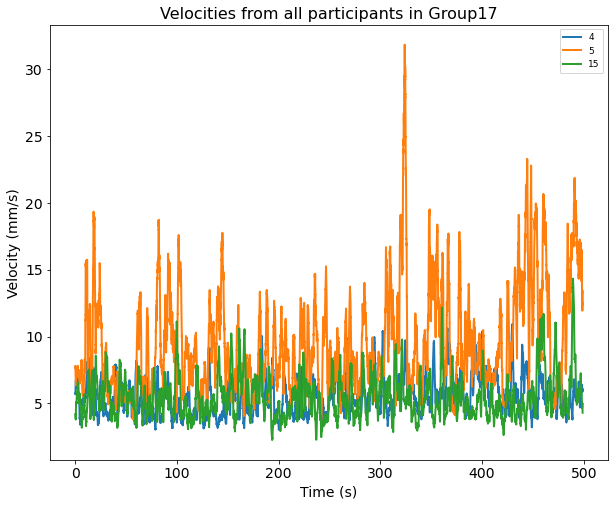

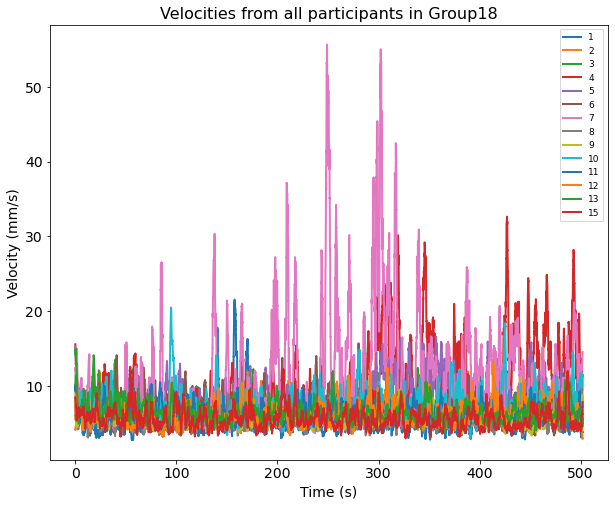

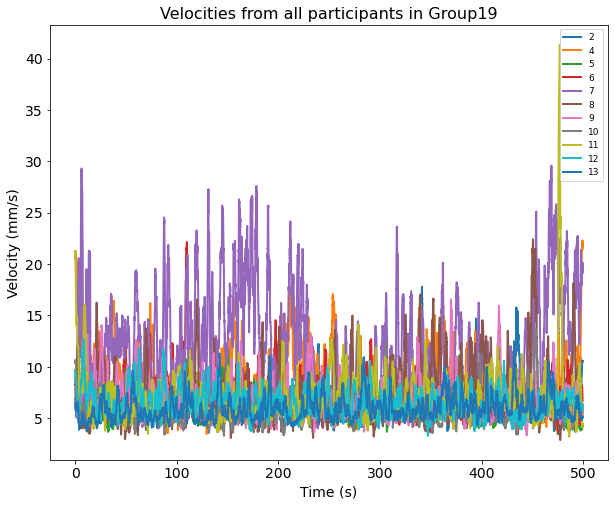

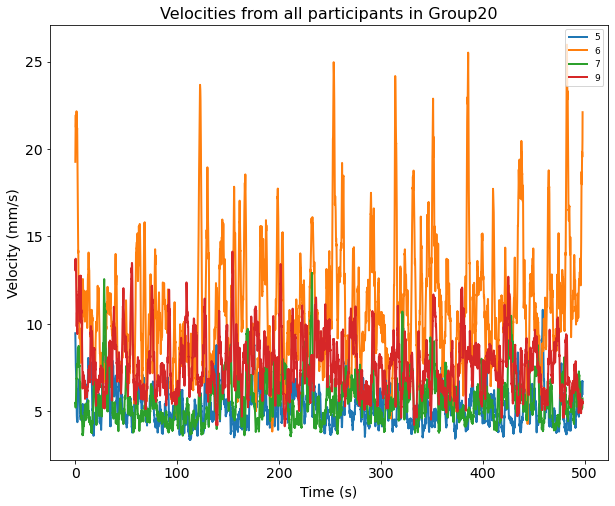

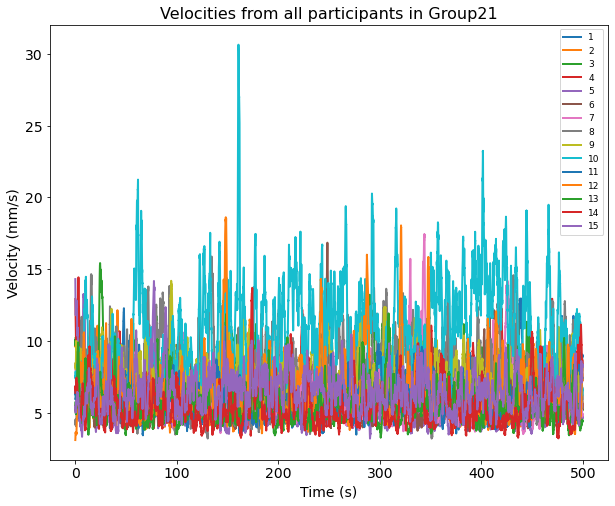

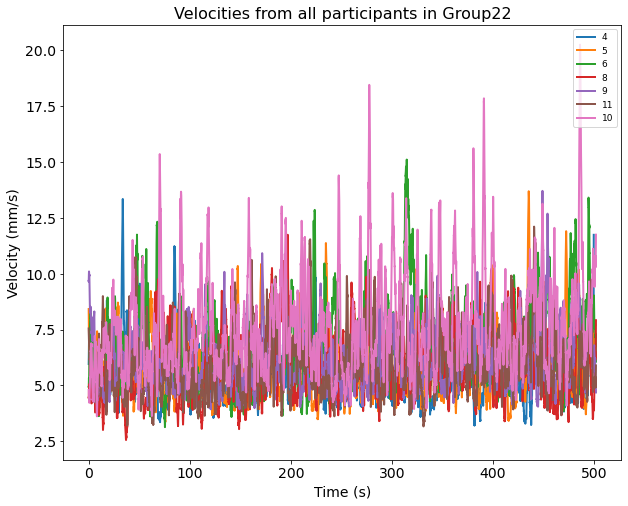

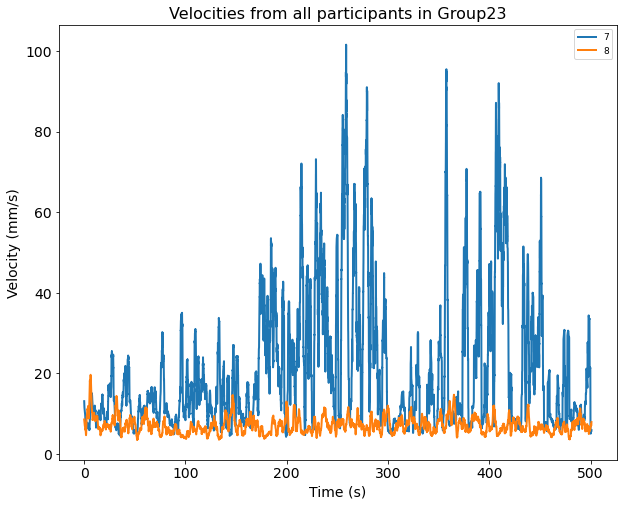

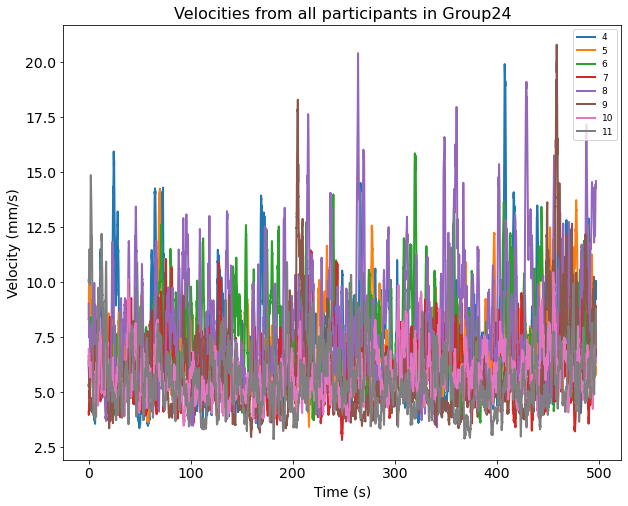

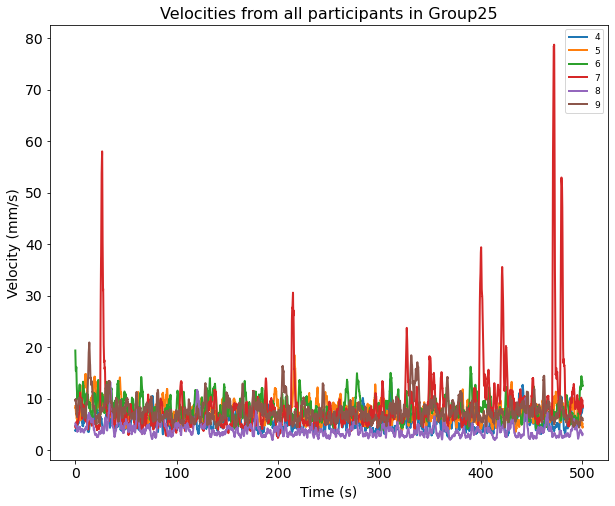

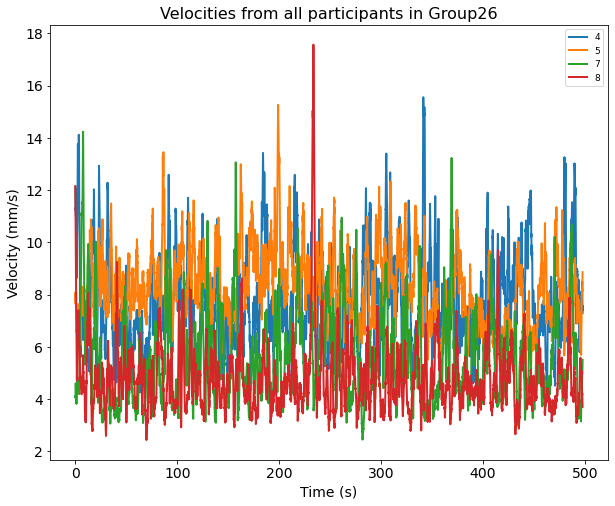

In [241]:
#Plotting all smoothed velocities for all groups
for grp in range(1, 27):
    ax1 = vel_env_group[grp].plot(figsize=(10,8), linewidth=2, fontsize=14)
    ax1.set_facecolor("white")
    plt.xlabel('Time (s)', fontsize=14);
    plt.ylabel('Velocity (mm/s)', fontsize=14);
    plt.legend(loc='upper right', fontsize=9)
    plt.title('Velocities from all participants in Group'+str(grp), fontsize=16)
    plt.savefig("Post_Exclusion_Smooth_Vel_Whole_Exp/Smoothed_Vel_Group"+str(grp)+".png")

C:\Users\danasw\AppData\Local\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


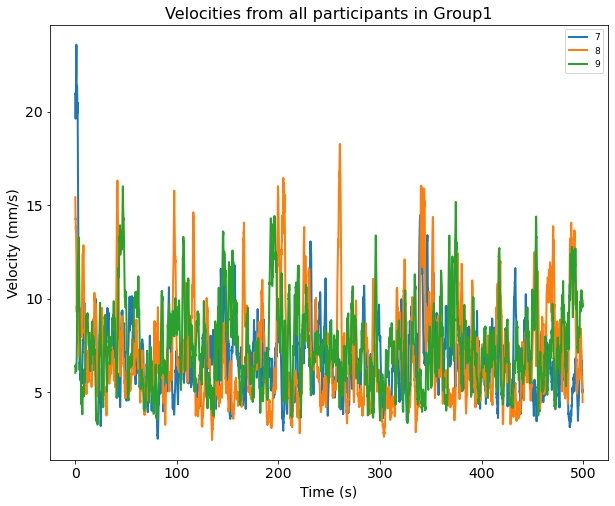

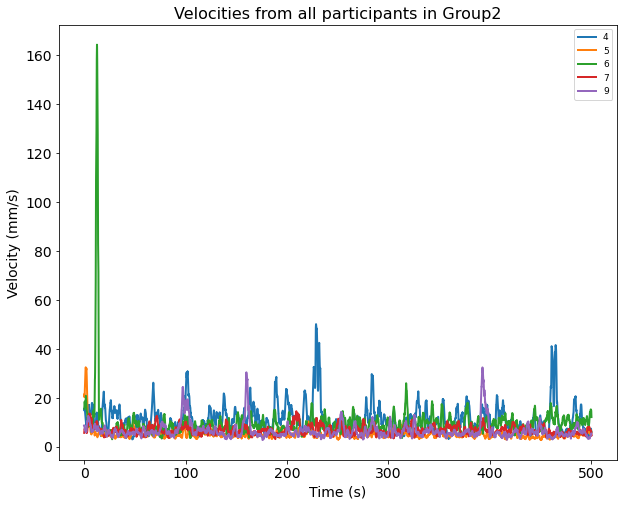

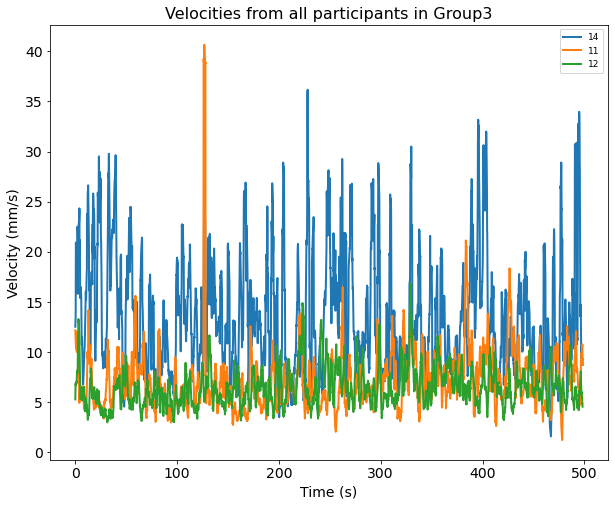

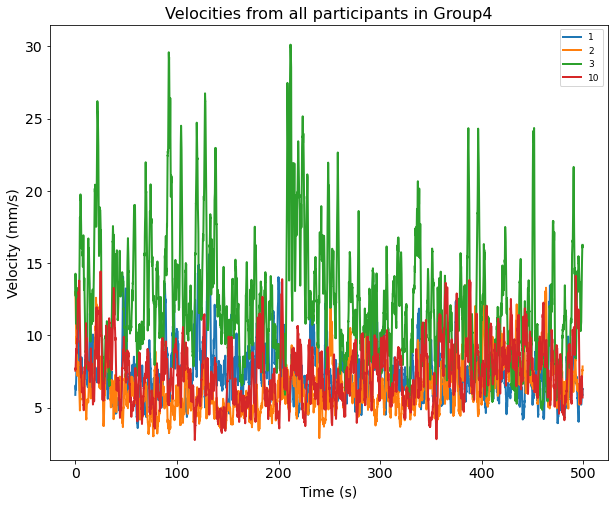

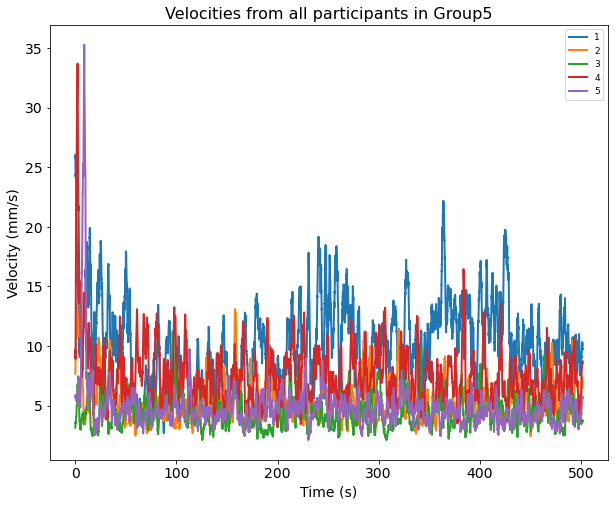

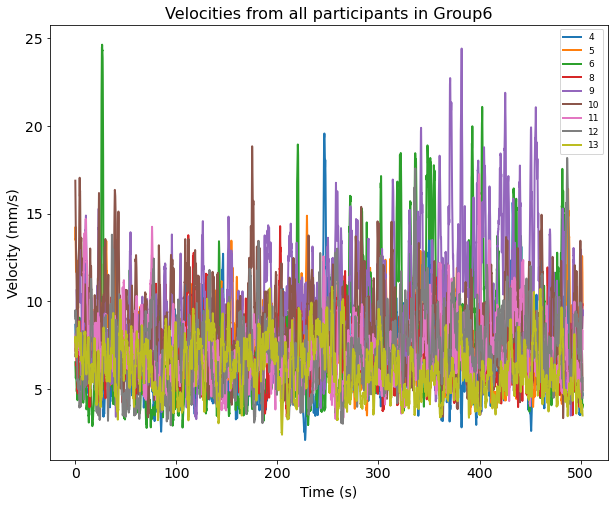

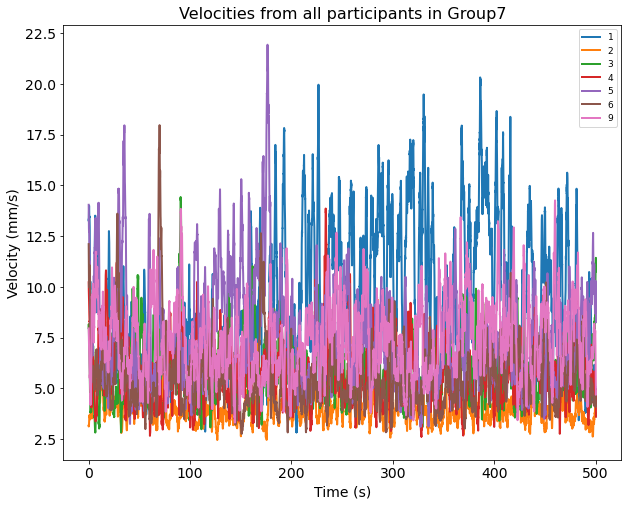

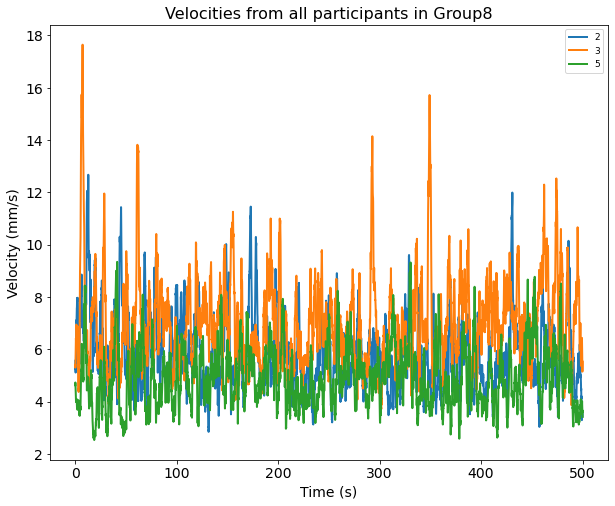

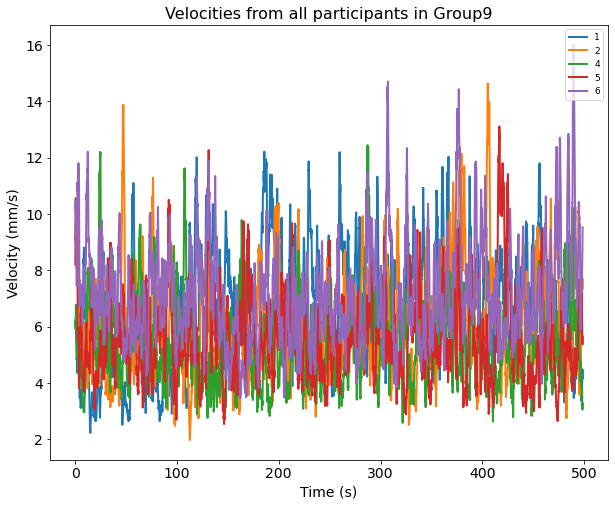

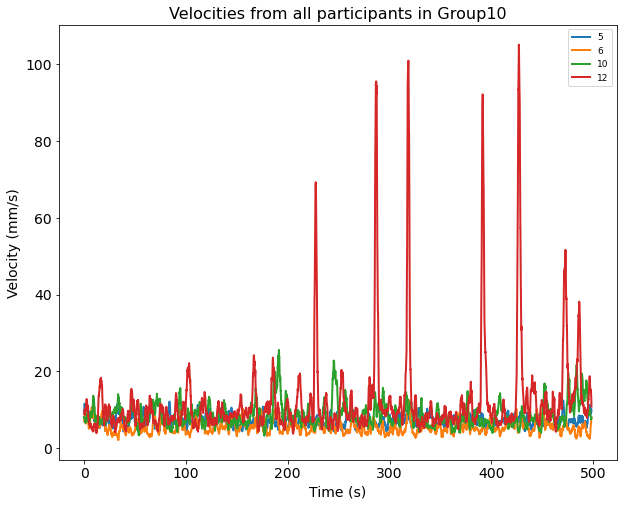

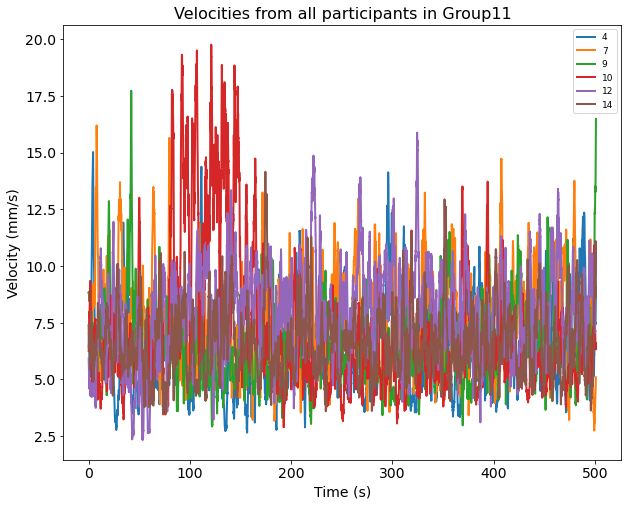

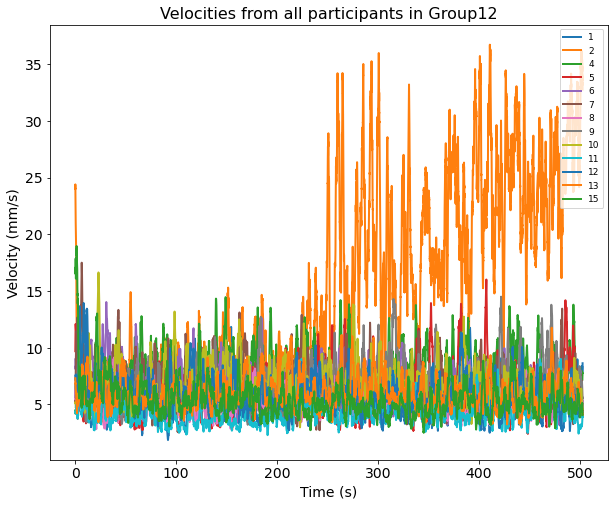

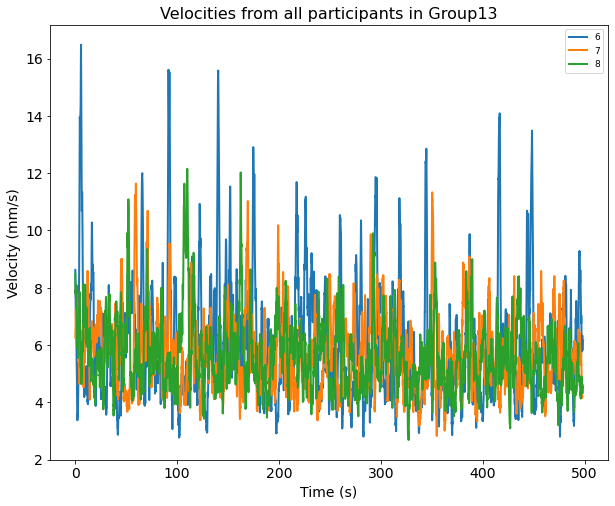

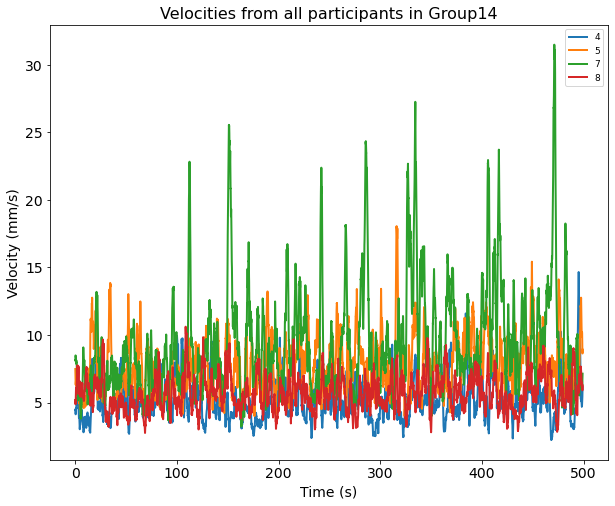

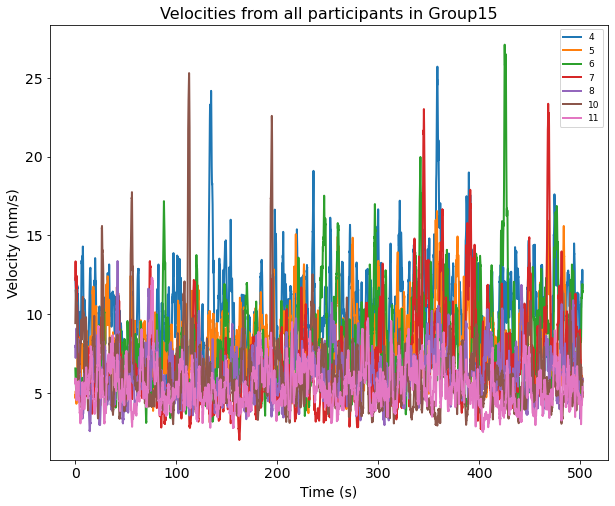

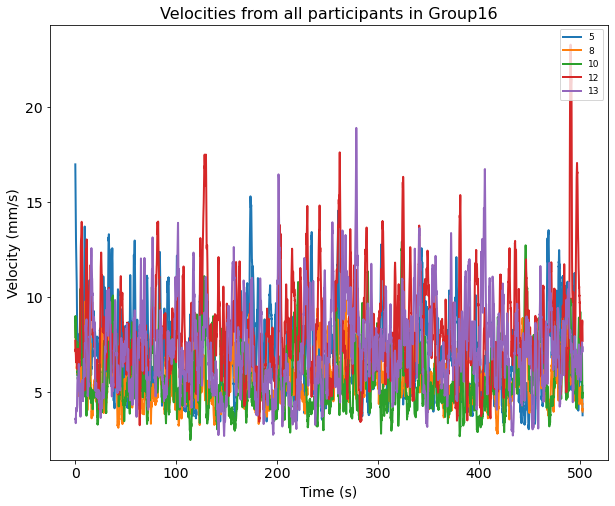

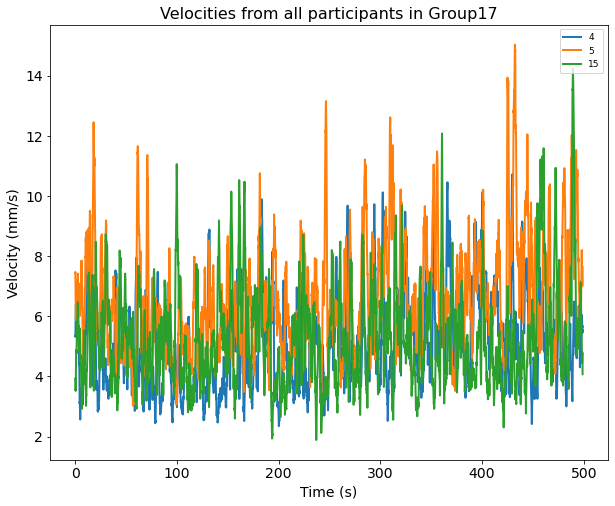

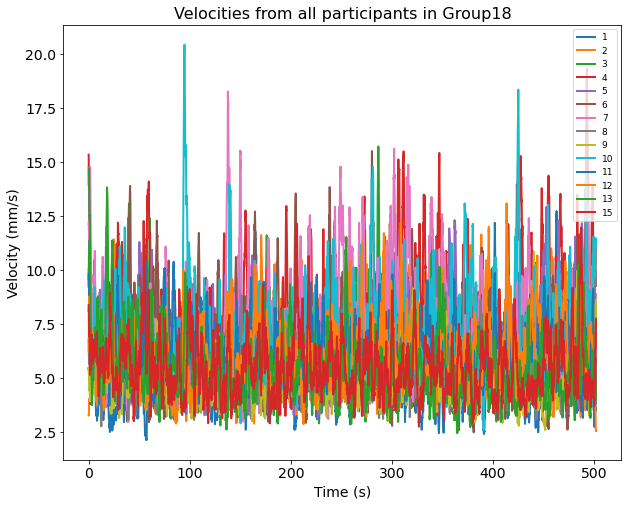

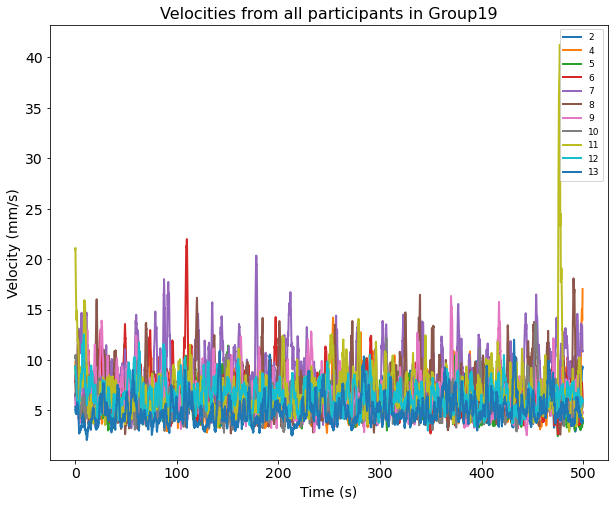

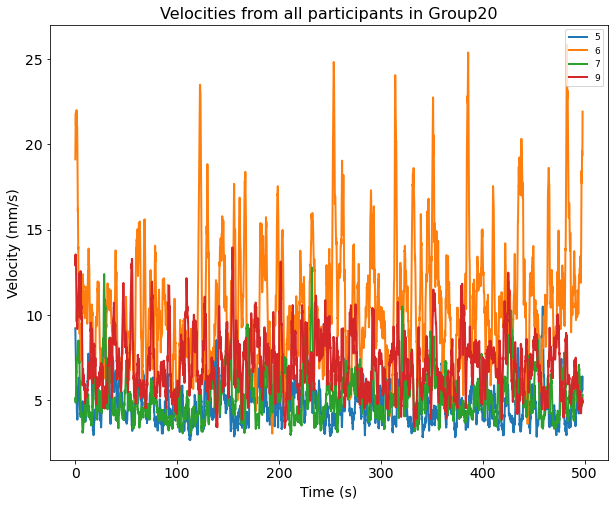

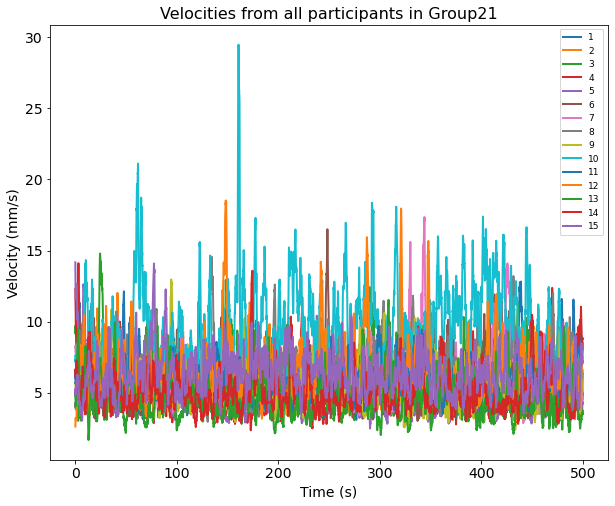

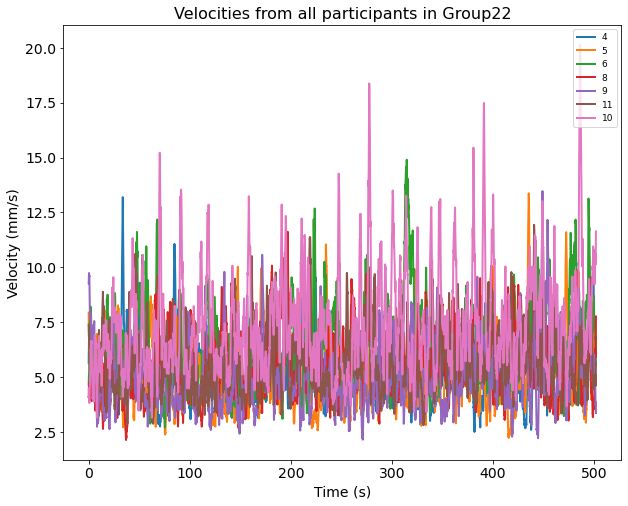

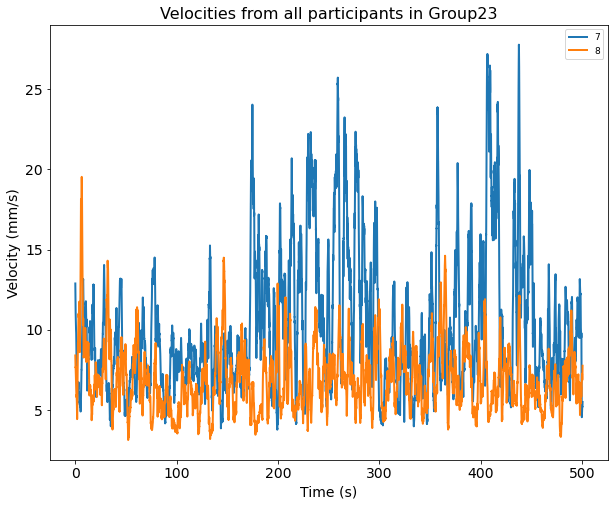

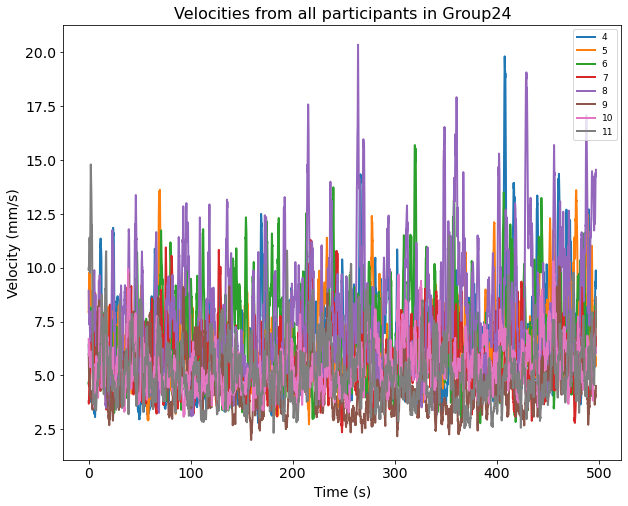

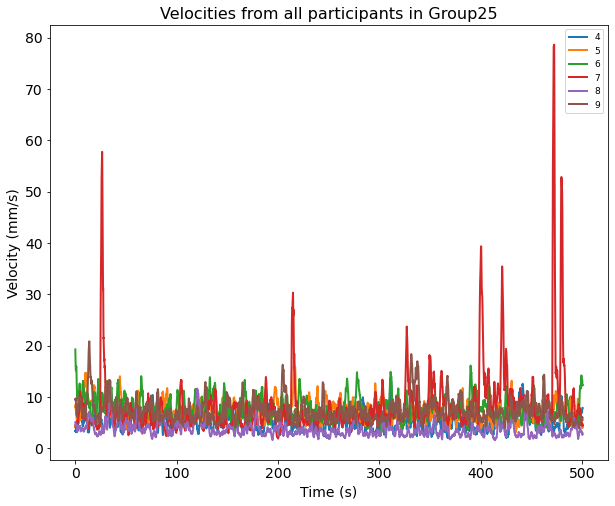

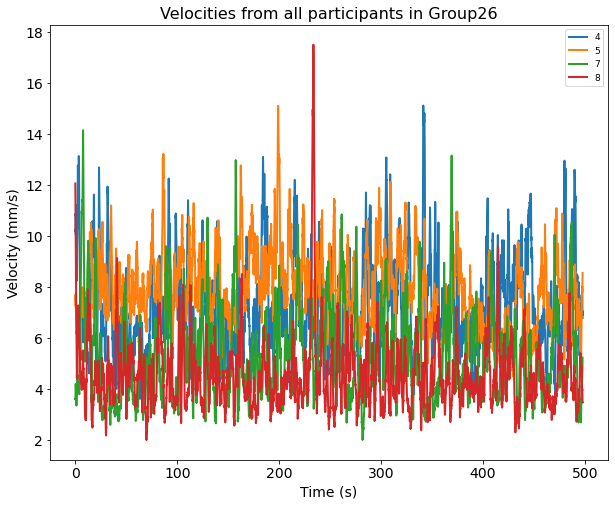

In [242]:
#Plotting all smoothed velocities for all groups
for grp in range(1, 27):
    ax1 = vel_env_groupSG[grp].plot(figsize=(10,8), linewidth=2, fontsize=14)
    ax1.set_facecolor("white")
    plt.xlabel('Time (s)', fontsize=14);
    plt.ylabel('Velocity (mm/s)', fontsize=14);
    plt.legend(loc='upper right', fontsize=9)
    plt.title('Velocities from all participants in Group'+str(grp), fontsize=16)
    plt.savefig("Post_Exclusion_Smooth_Vel_Whole_Exp/Smoothed_Vel_Group"+str(grp)+".png")

### Mean of Norm of the Velocity (mean QoM)

#### Raw

In [243]:
#Mean of cleaned velocities
mean_velocities = []

for groups in range(1,num_groups+1):
    
    for k,v in ec22[groups].items():
        vel = velocities[groups][k]
        mean = vel.mean()
        mean_velocities.append(
        {
            'Group': groups,
            'Participant': k, 
            'Mean_QoM': mean.iloc[0]
        })

In [244]:
mVels = pd.DataFrame(mean_velocities)
mVels

Group  Participant   Mean_QoM
0        1            7   7.021556
1        1            8   7.254963
2        1            9   8.303723
3        2            4  13.280771
4        2            5   5.469333
..     ...          ...        ...
155     25            9   7.629946
156     26            4   7.702948
157     26            5   8.290055
158     26            7   5.565451
159     26            8   4.821381

[160 rows x 3 columns]

In [245]:
mVels.to_csv("mean_QoM.csv", index = False)

#### Savgol 
13 samples, po = 3

In [246]:
#Mean of cleaned velocities
mean_velocitiesSG = []

for groups in range(1,num_groups+1):
    
    for k,v in ec22[groups].items():
        vel = velocities_savgol[groups][k]
        mean = vel.mean()
        mean_velocitiesSG.append(
        {
            'Group': groups,
            'Participant': k, 
            'Mean_QoM': mean.iloc[0]
        })

In [247]:
mVelsSG = pd.DataFrame(mean_velocitiesSG)
mVelsSG

Group  Participant   Mean_QoM
0        1            7   6.743571
1        1            8   7.003552
2        1            9   7.436159
3        2            4  11.299425
4        2            5   5.143081
..     ...          ...        ...
155     25            9   7.348915
156     26            4   7.194658
157     26            5   7.907198
158     26            7   5.298862
159     26            8   4.573292

[160 rows x 3 columns]

In [248]:
mVelsSG.to_csv("mean_QoM_Savgol.csv", index = False)

## Segmenting data by conditions and stimuli
Using the order of presentation of stimuli for each group to segment full trials into conditions (music-silence), and stimuli

In [249]:
#Stimuli presentation order
path = 'C:/Users/danasw/OneDrive/Documents/PhD/Research/Standstill/Data/'
file = 'Stimulus_Order.xlsx'
path_file = path+file
ec22_stim_order = pd.read_excel(path_file, sheet_name = 'Stimulus Order') #read the stimuli order file
ec22_stim_duration = pd.read_excel(path_file, sheet_name = 'Stimulus Duration and Key') #read the stimuli order file

ec22_stim_order.set_index('Group',inplace=True, drop=True)


In [250]:
ec22_stim_order

Stim1  Stim2  Stim3  Stim4  Stim5  Stim6  Stim7  Stim8  Stim9
Group                                                               
1          3      8      6      2      1      9      5      4      7
2          7      2      3      5      8      9      6      4      1
3          4      1      8      2      6      5      9      3      7
4          9      2      8      7      6      1      3      5      4
5          3      6      9      5      2      1      8      7      4
6          4      1      5      7      6      2      3      9      8
7          1      8      3      2      4      5      7      9      6
8          7      9      8      1      4      2      6      5      3
9          8      7      6      4      9      5      3      1      2
10         8      1      3      4      2      7      5      6      9
11         8      7      2      6      1      9      4      5      3
12         2      7      9      8      1      3      5      4      6
13         5      6      8      1      4      2      7      3      9
14         8      1      5      7      3      6      9      4      2
15         6      2      3      4      1      9      8      7      5
16         2      7      8      1      9      6      3      4      5
17         5      1      7      4      3      8      9      6      2
18         9      2      4      5      1      6      7      3      8
19         2      9      5      4      6      1      8      3      7
20         8      6      3      2      5      4      9      1      7
21         6      7      2      5      1      8      3      4      9
22         4      8      5      9      3      1      7      6      2
23         2      6      5      1      8      4      9      7      3
24         1      4      7      6      8      3      5      2      9
25         3      5      7      8      6      9      1      2      4
26         1      3      8      5      7      6      2      4      9

In [251]:
ec22_stim_dur = ec22_stim_duration.iloc[:, :3]

In [252]:
ec22_stim_dur

Stimulus                         Name   Dur_s
0         1            Drums_43_Poly.wav  25.000
1         2          Drums_Metronome.wav  25.000
2         3              Drums_OnOff.wav  25.000
3         4             Drums_Random.wav  25.000
4         5  Music_HighGrooveHighFam.wav  29.908
5         6   Music_HighGrooveLowFam.wav  29.843
6         7         Music_Hoppipolla.wav  61.972
7         8   Music_LowGrooveHighFam.wav  29.403
8         9    Music_LowGrooveLowFam.wav  64.844

### Segmenting group data by songs based on the order of stimuli presentation

In [253]:
## Check how song order is being defined to make sure that this is working. 
group_id = 25
songorder = ec22_stim_order[group_id-1:group_id]
songorder

Stim1  Stim2  Stim3  Stim4  Stim5  Stim6  Stim7  Stim8  Stim9
Group                                                               
25         3      5      7      8      6      9      1      2      4

In [254]:
def segments(songorder,data):
    # edited May 2024 to cut the end off of hoppipolla and every breaking wave to make them 30s long and thus comparable to the other excerpts.
    
    #edited for EC2022
    #works for mocap data at 120hz, song duration used in EC2022
    #all silence = 20s
    # data's index must be in seconds.
    
    ## STIMULI
    #1 - 25s
    #2 - 25s
    #3 - 25s
    #4 - 25s
    #5 - 29.908
    #6 - 29.843
    #7 - 61.972
    #8 - 29.403
    #9 - 64.844
    
    ## STIMULI & Silence
    #1 - 20s silence
    #2 - 25s drums_43
    #3 - 20s silence
    #4 - 25s drums_metronome
    #5 - 20s silence
    #6 - 25s drums_onoff
    #7 - 20s silence
    #8 - 25s drums_random
    #9 - 20s silence
    #10 - 29.908 s music_HighGrooveHighFam
    #11 - 20s silence
    #12 - 29.843 s music_HighGrooveLowFam
    #13 - 20s silence
    #14 - 61.972 s Hoppipolla
    #15 - 20s silence
    #16 - 29.403 s music_LowGrooveHighFam
    #17 - 20s silence
    #18 - 64.844 s music_LowGrooveLowFam
    
    # There was no silence after the last excerpt. 
    
    start = {} # should be song start
    segments = {}
    #segments[1] = data[15:46] #First segement starting after 15 seconds - why did they cut 15 seconds off the beginning of the first silence? Probably becasue a lot of people settle into the stillness in the frst silence so it is not a good comparison. 
    #start[1] = 15
    #start[2] = 45
    
    segments[1] = data[0:20] #First silence segment was 20 seconds 
    start[1] = 0
    start[2] = 20
    
    song = 0 # counting song order
    while song <= len(songorder.columns)-1:
        for inicio in range (2,19,2): # starting at 2 because the first silence is accounted for above. skipping by 2 because this is just for the song starts and not the silences?
            if songorder.iloc[0][song] == 1:
                        segments[inicio]=data[start[inicio]:start[inicio]+25] #song1 25s
                        segments[inicio+1]=data[start[inicio]+25:start[inicio]+25+20] #20s silence
                        start[inicio+2] = start[inicio]+25+20
                        song = song+1  
            elif songorder.iloc[0][song] == 2:
                        segments[inicio]=data[start[inicio]:start[inicio]+25] #song2 25s
                        segments[inicio+1]=data[start[inicio]+25:start[inicio]+25+20] #20s silence
                        start[inicio+2] = start[inicio]+25+20
                        song = song+1
            elif songorder.iloc[0][song] == 3:
                        segments[inicio]=data[start[inicio]:start[inicio]+25] #song3 25s
                        segments[inicio+1]=data[start[inicio]+25:start[inicio]+25+20] #20s silence
                        start[inicio+2] = start[inicio]+25+20
                        song = song+1
            elif songorder.iloc[0][song] == 4:
                        segments[inicio]=data[start[inicio]:start[inicio]+25] #song4 25s
                        segments[inicio+1]=data[start[inicio]+25:start[inicio]+25+20] #20s silence
                        start[inicio+2] = start[inicio]+25+20
                        song = song+1
            elif songorder.iloc[0][song] == 5:
                        segments[inicio]=data[start[inicio]:start[inicio]+29.908] #song5 29.908
                        segments[inicio+1]=data[start[inicio]+29.908:start[inicio]+29.908+20] #20s silence
                        start[inicio+2] = start[inicio]+29.908+20
                        song = song+1
            elif songorder.iloc[0][song] == 6:
                        segments[inicio]=data[start[inicio]:start[inicio]+29.843] #song6 29.843
                        segments[inicio+1]=data[start[inicio]+29.843:start[inicio]+29.843+20] #20s silence
                        start[inicio+2] = start[inicio]+29.843+20
                        song = song+1
            elif songorder.iloc[0][song] == 7:
                        segments[inicio]=data[start[inicio]:start[inicio]+30] #song7 61.972 # UPDATED MAY 2024 to shorten to 30 s, but the silence should stay the same.
                        segments[inicio+1]=data[start[inicio]+61.972:start[inicio]+61.972+20] #20s silence
                        start[inicio+2] = start[inicio]+61.972+20
                        song = song+1
            elif songorder.iloc[0][song] == 8:
                        segments[inicio]=data[start[inicio]:start[inicio]+29.403] #song8 29.403
                        segments[inicio+1]=data[start[inicio]+29.403:start[inicio]+29.403+20] #20s silence
                        start[inicio+2] = start[inicio]+29.403+20
                        song = song+1
            elif songorder.iloc[0][song] == 9:
                        segments[inicio]=data[start[inicio]:start[inicio]+30] #song9 64.844 # UPDATED MAY 2024 to shorten to 30 s, but the silence should stay the same.
                        segments[inicio+1]=data[start[inicio]+64.844:start[inicio]+64.844+20] #20s silence
                        start[inicio+2] = start[inicio]+64.844+20
                        song = song+1
    return segments

### Segmenting raw and smoothed Velocity (QoM) and interpolated QoM

In [255]:
vels_group[1].index

Index([0.008333333333333333, 0.016666666666666666,                0.025,
        0.03333333333333333, 0.041666666666666664,                 0.05,
       0.058333333333333334,  0.06666666666666667,                0.075,
        0.08333333333333333,
       ...
         499.43333333333334,   499.44166666666666,               499.45,
          499.4583333333333,   499.46666666666664,              499.475,
         499.48333333333335,    499.4916666666667,                499.5,
          499.5083333333333],
      dtype='float64', name='time_s', length=59941)

In [256]:
QoM_segmented = {}
QoMX_segmented = {}
QoMY_segmented = {}
QoMZ_segmented = {}

for group_id in range(1,num_groups+1):
    QoM_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],vels_group[group_id])
    QoMX_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],velsx_group[group_id])
    QoMY_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],velsy_group[group_id])
    QoMZ_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],velsz_group[group_id])
    
QoM_smooth_segmented = {}
QoMX_smooth_segmented = {}
QoMY_smooth_segmented = {}
QoMZ_smooth_segmented = {}

for group_id in range(1,num_groups+1):
    QoM_smooth_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_env_group[group_id])
    QoMX_smooth_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_envx_group[group_id])
    QoMY_smooth_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_envy_group[group_id])
    QoMZ_smooth_segmented[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_envz_group[group_id])
    

C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\238534806.py:48: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  segments[1] = data[0:20] #First silence segment was 20 seconds
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\238534806.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if songorder.iloc[0][song] == 1:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\238534806.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[

In [257]:
# SAVGOL
QoM_segmented_SG = {}
QoMX_segmented_SG = {}
QoMY_segmented_SG = {}
QoMZ_segmented_SG = {}

for group_id in range(1,num_groups+1):
    QoM_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],vels_group_sg[group_id])
    QoMX_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],velsx_group_sg[group_id])
    QoMY_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],velsy_group_sg[group_id])
    QoMZ_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],velsz_group_sg[group_id])
    
QoM_smooth_segmented_SG = {}
QoMX_smooth_segmented_SG = {}
QoMY_smooth_segmented_SG = {}
QoMZ_smooth_segmented_SG = {}

for group_id in range(1,num_groups+1):
    QoM_smooth_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_env_groupSG[group_id])
    QoMX_smooth_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_envx_groupSG[group_id])
    QoMY_smooth_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_envy_groupSG[group_id])
    QoMZ_smooth_segmented_SG[group_id] = segments(ec22_stim_order[group_id-1:group_id],vel_envz_groupSG[group_id])
    

C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\238534806.py:48: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  segments[1] = data[0:20] #First silence segment was 20 seconds
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\238534806.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if songorder.iloc[0][song] == 1:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\238534806.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[

In [258]:
QoM_segmented[25][1] #Displaying QoM data for group 25, segment 1

4          5          6         7         8          9
time_s                                                                  
0.008333   3.575726  14.087594  20.071684  5.914877  2.874943  20.262698
0.016667   1.567497  15.210569  24.156913  6.307728  3.101691  19.285568
0.025000   2.477358  14.686156  26.783956  4.274733  1.962208  17.113059
0.033333   2.309128  16.047326  25.020884  6.389351  3.419861  20.629866
0.041667   5.300919  14.282145  26.181950  3.661566  1.443459  17.532133
...             ...        ...        ...       ...       ...        ...
19.966667  4.143523   8.701853   3.905081  4.273905  2.125727   2.532298
19.975000  4.009022  14.653517   4.677829  4.061109  0.892657   3.571738
19.983333  3.086821  10.103481   5.906020  4.543928  1.040194   2.865108
19.991667  4.397014   8.264181   4.801281  5.685058  1.866220   4.325383
20.000000  3.379633  12.931872   7.200619  5.194185  1.748084   1.473416

[2400 rows x 6 columns]

### Grouping data into Music and Silence conditions

In [259]:
#Odd segments are silence, even segments are music
QoM_segmented_mus = {} #creating empty dictionaries for music and silence
QoMX_segmented_mus = {}
QoMY_segmented_mus = {}
QoMZ_segmented_mus = {}

QoM_segmented_sil = {}
QoMX_segmented_sil = {}
QoMY_segmented_sil = {}
QoMZ_segmented_sil = {}

QoM_smooth_segmented_mus = {}
QoMX_smooth_segmented_mus = {}
QoMY_smooth_segmented_mus = {}
QoMZ_smooth_segmented_mus = {}

QoM_smooth_segmented_sil = {}
QoMX_smooth_segmented_sil = {}
QoMY_smooth_segmented_sil = {}
QoMZ_smooth_segmented_sil = {}


for group_id in range(1,num_groups+1):
    QoM_segmented_mus[group_id] = {} #creating empty dictionary for each group for both music and silence conditions
    QoMX_segmented_mus[group_id] = {}
    QoMY_segmented_mus[group_id] = {}
    QoMZ_segmented_mus[group_id] = {}

    QoM_segmented_sil[group_id] = {}
    QoMX_segmented_sil[group_id] = {}
    QoMY_segmented_sil[group_id] = {}
    QoMZ_segmented_sil[group_id] = {}

    QoM_smooth_segmented_mus[group_id] = {}
    QoMX_smooth_segmented_mus[group_id] = {}
    QoMY_smooth_segmented_mus[group_id] = {}
    QoMZ_smooth_segmented_mus[group_id] = {}

    QoM_smooth_segmented_sil[group_id] = {}
    QoMX_smooth_segmented_sil[group_id] = {}
    QoMY_smooth_segmented_sil[group_id] = {}
    QoMZ_smooth_segmented_sil[group_id] = {}
    
    k = 0
    ksil=0
    
    for j in range (1,19,2): 
        QoM_segmented_sil[group_id][ksil] = QoM_segmented[group_id][j] #filling each participant's dictionary with odd segments (silence)
        QoM_smooth_segmented_sil[group_id][ksil] = QoM_smooth_segmented[group_id][j]
        

        QoMX_segmented_sil[group_id][ksil] = QoMX_segmented[group_id][j] 
        QoMX_smooth_segmented_sil[group_id][ksil] = QoMX_smooth_segmented[group_id][j]
        
        
        QoMY_segmented_sil[group_id][ksil] = QoMY_segmented[group_id][j] 
        QoMY_smooth_segmented_sil[group_id][ksil] = QoMY_smooth_segmented[group_id][j]
        
        
        QoMZ_segmented_sil[group_id][ksil] = QoMZ_segmented[group_id][j] 
        QoMZ_smooth_segmented_sil[group_id][ksil] = QoMZ_smooth_segmented[group_id][j]
        
        
        
        ksil=ksil+1
    
    #for i in range (1,19,2):  
        QoM_segmented_mus[group_id][k] = QoM_segmented[group_id][j+1] #filling each participant's dictionary with even segments (music)
        QoM_smooth_segmented_mus[group_id][k] = QoM_smooth_segmented[group_id][j+1]
        


        QoMX_smooth_segmented_mus[group_id][k] = QoMX_smooth_segmented[group_id][j+1]
        QoMX_segmented_mus[group_id][k] = QoMX_segmented[group_id][j+1] 
        
        
        QoMY_smooth_segmented_mus[group_id][k] = QoMY_smooth_segmented[group_id][j+1]
        QoMY_segmented_mus[group_id][k] = QoMY_segmented[group_id][j+1] 
        
        
        QoMZ_smooth_segmented_mus[group_id][k] = QoMZ_smooth_segmented[group_id][j+1]
        QoMZ_segmented_mus[group_id][k] = QoMZ_segmented[group_id][j+1] 
        
        
        k=k+1

In [260]:
# SAVGOL
#Odd segments are silence, even segments are music
QoM_segmented_mus_sg = {} #creating empty dictionaries for music and silence
QoMX_segmented_mus_sg = {}
QoMY_segmented_mus_sg = {}
QoMZ_segmented_mus_sg = {}

QoM_segmented_sil_sg = {}
QoMX_segmented_sil_sg = {}
QoMY_segmented_sil_sg = {}
QoMZ_segmented_sil_sg = {}

QoM_smooth_segmented_mus_sg = {}
QoMX_smooth_segmented_mus_sg = {}
QoMY_smooth_segmented_mus_sg = {}
QoMZ_smooth_segmented_mus_sg = {}

QoM_smooth_segmented_sil_sg = {}
QoMX_smooth_segmented_sil_sg = {}
QoMY_smooth_segmented_sil_sg = {}
QoMZ_smooth_segmented_sil_sg = {}


for group_id in range(1,num_groups+1):
    QoM_segmented_mus_sg[group_id] = {} #creating empty dictionary for each group for both music and silence conditions
    QoMX_segmented_mus_sg[group_id] = {}
    QoMY_segmented_mus_sg[group_id] = {}
    QoMZ_segmented_mus_sg[group_id] = {}

    QoM_segmented_sil_sg[group_id] = {}
    QoMX_segmented_sil_sg[group_id] = {}
    QoMY_segmented_sil_sg[group_id] = {}
    QoMZ_segmented_sil_sg[group_id] = {}

    QoM_smooth_segmented_mus_sg[group_id] = {}
    QoMX_smooth_segmented_mus_sg[group_id] = {}
    QoMY_smooth_segmented_mus_sg[group_id] = {}
    QoMZ_smooth_segmented_mus_sg[group_id] = {}

    QoM_smooth_segmented_sil_sg[group_id] = {}
    QoMX_smooth_segmented_sil_sg[group_id] = {}
    QoMY_smooth_segmented_sil_sg[group_id] = {}
    QoMZ_smooth_segmented_sil_sg[group_id] = {}
    
    k = 0
    ksil=0
    
    for j in range (1,19,2): 
        QoM_segmented_sil_sg[group_id][ksil] = QoM_segmented_SG[group_id][j] #filling each participant's dictionary with odd segments (silence)
        QoM_smooth_segmented_sil_sg[group_id][ksil] = QoM_smooth_segmented_SG[group_id][j]
        

        QoMX_segmented_sil_sg[group_id][ksil] = QoMX_segmented_SG[group_id][j] 
        QoMX_smooth_segmented_sil_sg[group_id][ksil] = QoMX_smooth_segmented_SG[group_id][j]
        
        
        QoMY_segmented_sil_sg[group_id][ksil] = QoMY_segmented_SG[group_id][j] 
        QoMY_smooth_segmented_sil_sg[group_id][ksil] = QoMY_smooth_segmented_SG[group_id][j]
        
        
        QoMZ_segmented_sil_sg[group_id][ksil] = QoMZ_segmented_SG[group_id][j] 
        QoMZ_smooth_segmented_sil_sg[group_id][ksil] = QoMZ_smooth_segmented_SG[group_id][j]
        
        
        
        ksil=ksil+1
    
    #for i in range (1,19,2):  
        QoM_segmented_mus_sg[group_id][k] = QoM_segmented_SG[group_id][j+1] #filling each participant's dictionary with even segments (music)
        QoM_smooth_segmented_mus_sg[group_id][k] = QoM_smooth_segmented_SG[group_id][j+1]
        


        QoMX_smooth_segmented_mus_sg[group_id][k] = QoMX_smooth_segmented_SG[group_id][j+1]
        QoMX_segmented_mus_sg[group_id][k] = QoMX_segmented_SG[group_id][j+1] 
        
        
        QoMY_smooth_segmented_mus_sg[group_id][k] = QoMY_smooth_segmented_SG[group_id][j+1]
        QoMY_segmented_mus_sg[group_id][k] = QoMY_segmented_SG[group_id][j+1] 
        
        
        QoMZ_smooth_segmented_mus_sg[group_id][k] = QoMZ_smooth_segmented_SG[group_id][j+1]
        QoMZ_segmented_mus_sg[group_id][k] = QoMZ_segmented_SG[group_id][j+1] 
        
        
        k=k+1

In [261]:
QoM_segmented_mus[25][0] #Smoothed Group25 music segment1

4          5          6         7         8         9
time_s                                                                 
20.000000  3.379633  12.931872   7.200619  5.194185  1.748084  1.473416
20.008333  3.168626   8.072938   2.349474  4.815585  1.917671  1.892032
20.016667  4.285736   9.809479   7.217133  6.810719  1.785412  3.050723
20.025000  1.597228  13.206083   3.712428  2.889774  1.940456  1.779176
20.033333  3.851094   7.348650   2.319963  5.406268  1.994304  2.793627
...             ...        ...        ...       ...       ...       ...
44.966667  2.952660  10.137230   5.912448  7.010262  2.440891  7.107952
44.975000  4.873384   7.223113   9.938597  8.100547  1.974926  7.942304
44.983333  1.412505  11.513999   8.483817  5.560114  1.603464  6.489341
44.991667  6.338026   6.489453  10.604268  6.551413  2.677449  7.257983
45.000000  2.470649  10.851526   7.784428  6.603177  1.459213  8.799293

[3001 rows x 6 columns]

### Mean QoM for each segment for each participant

In [262]:
# Mean QoM for each participant in each group for each segment

Mean_QoM_segm = {}    

for qoms_group in range(1,num_groups+1):
    Mean_QoM_segm[qoms_group] = {}
    
    for i in range(1,len(QoM_segmented[qoms_group]) + 1):
        Mean_QoM_segm[qoms_group][i] = (QoM_segmented[qoms_group][i].mean())*1000 #Calculating mean QoM and converting from m/s to mm/s
       

In [263]:
# SAVGOL
# Mean QoM for each participant in each group for each segment

Mean_QoM_segm_SG = {}    

for qoms_group in range(1,num_groups+1):
    Mean_QoM_segm_SG[qoms_group] = {}
    
    for i in range(1,len(QoM_segmented_SG[qoms_group]) + 1):
        Mean_QoM_segm_SG[qoms_group][i] = (QoM_segmented_SG[qoms_group][i].mean())*1000 #Calculating mean QoM and converting from m/s to mm/s
       

In [264]:
Mean_QoM_segm[25][5] #Displaying mean QoM for participants in group 10, 5th segment

4    5751.034318
5    6350.871736
6    7239.581913
7    6094.427734
8    4287.108765
9    6696.626080
dtype: float64

In [265]:
Mean_QoM_segm_SG[25][5] #Displaying mean QoM for participants in group 10, 5th segment

4    5430.035493
5    6091.957108
6    6892.366812
7    5823.245371
8    4097.750408
9    6400.724782
dtype: float64

In [266]:
group_list = []
stim_list = []
pt_list = []
mean_QoM_list = []

# iterate through the segments of music to create dataframe with segments as they were played in the order that they were played.
for k,v in QoM_segmented_mus.items():
    for stim in range(0,len(ec22_stim_order.columns)):
        stim_qom = v[stim]
        for pt in stim_qom.columns:
            group_list.append(k)
            stim_list.append(stim)
            pt_list.append(pt)
            mean_QoM_list.append(QoM_segmented_mus[k][stim][pt].mean())
mean_QoM = {
    'Group': group_list,
    'Stimuli': stim_list,
    'Participant': pt_list,
    'mean_QoM': mean_QoM_list
}
ind_array = [group_list, stim_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Stim', 'Pt'))
Mean_QoM_df_unsorted = pd.DataFrame(mean_QoM_list, index = ind)

In [267]:
#SAVGOL
group_list = []
stim_list = []
pt_list = []
mean_QoM_list = []

# iterate through the segments of music to create dataframe with segments as they were played in the order that they were played.
for k,v in QoM_segmented_mus_sg.items():
    for stim in range(0,len(ec22_stim_order.columns)):
        stim_qom = v[stim]
        for pt in stim_qom.columns:
            group_list.append(k)
            stim_list.append(stim)
            pt_list.append(pt)
            mean_QoM_list.append(QoM_segmented_mus_sg[k][stim][pt].mean())
mean_QoM = {
    'Group': group_list,
    'Stimuli': stim_list,
    'Participant': pt_list,
    'mean_QoM': mean_QoM_list
}
ind_array = [group_list, stim_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Stim', 'Pt'))
Mean_QoM_df_unsorted_SG = pd.DataFrame(mean_QoM_list, index = ind)

In [268]:
unsorted_unstacked_mean_qom_df = Mean_QoM_df_unsorted.unstack('Stim')

In [269]:
unsorted_unstacked_mean_qom_df_SG = Mean_QoM_df_unsorted_SG.unstack('Stim')

(0.0, 15.0)

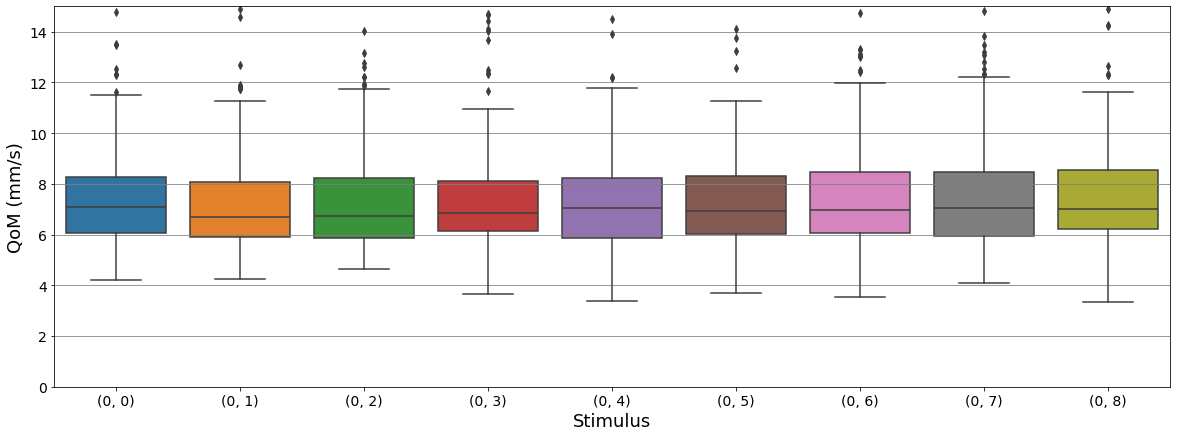

In [270]:
#Box plot of QoM by Stimulus (not sorted, just in order as they were presented)

figbox, axbox = plt.subplots(figsize=(20,7))
qombox = seaborn.boxplot(ax=axbox, data=unsorted_unstacked_mean_qom_df, width=0.8)
axbox.set_facecolor("white")
axbox.yaxis.grid(color='gray')
qombox.set_xlabel("Stimulus",fontsize=18)
qombox.set_ylabel("QoM (mm/s)",fontsize=18)
qombox.tick_params(labelsize=14)
plt.ylim(0, 15)

In [271]:
unsorted_unstacked_mean_qom_df.describe()

0                          ...                                    
Stim            0           1           2  ...           6           7           8
count  160.000000  160.000000  160.000000  ...  160.000000  160.000000  160.000000
mean     7.605275    7.362386    7.744600  ...    8.657005    9.047239    8.591869
std      2.749263    2.731648    3.323280  ...    8.230848   10.078777    9.184005
min      4.215624    4.232362    4.626366  ...    3.544995    4.110666    3.340775
25%      6.049797    5.894387    5.868675  ...    6.050045    5.957203    6.228637
50%      7.096151    6.709013    6.736999  ...    6.971201    7.037114    7.028171
75%      8.281577    8.059611    8.229815  ...    8.485118    8.457795    8.555502
max     29.663235   25.359271   30.126919  ...   95.959658  113.139294  117.096864

[8 rows x 9 columns]

Previously, before excluding: 
Based on these means, if I had to speculate, I would definitely guess that there was an order effect and that people move more towards the end of the session. Therefore, when I conduct a mixed effects model I should build a model with an order variable as well to see if that contributes to quantity of motion.

### Sorting Music data by Stimuli
1. Drums_43_Poly
2. Drums_Metronome
3. Drums_OnOff
4. Drums_Random
5. Music_HighGrooveHighFam
6. Music_HighGrooveLowFam
7. Music_Hoppipolla
8. Music_LowGrooveHighFam
9. Music_LowGrooveLowFam

In [272]:
## Function to assign segments to stimuli based on the order of presentation for each group

def sort_stimuli(songorder,data):
   
    sorted_stimuli = {}
    song = 0
    while song <= len(songorder.columns)-1:
            if songorder.iloc[0][song] == 1:
                       sorted_stimuli[1] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 2:
                       sorted_stimuli[2] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 3:
                       sorted_stimuli[3] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 4:
                       sorted_stimuli[4] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 5:
                       sorted_stimuli[5] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 6:
                       sorted_stimuli[6] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 7:
                       sorted_stimuli[7] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 8:
                       sorted_stimuli[8] = data[song]
                       song = song+1
            elif songorder.iloc[0][song] == 9:
                       sorted_stimuli[9] = data[song]
                       song = song+1
    return sorted_stimuli

In [273]:
## Running stimuli sorting function for full Music data from all groups
QoM_segmented_sort_mus = {}
QoMX_segmented_sort_mus = {}
QoMY_segmented_sort_mus = {}
QoMZ_segmented_sort_mus = {}

QoM_smooth_segmented_sort_mus = {}
QoMX_smooth_segmented_sort_mus = {}
QoMY_smooth_segmented_sort_mus = {}
QoMZ_smooth_segmented_sort_mus = {}

for group_id in range(1,num_groups+1):  
    QoM_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_segmented_mus[group_id])
    QoMX_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_segmented_mus[group_id])
    QoMY_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_segmented_mus[group_id])
    QoMZ_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_segmented_mus[group_id])
    
    QoM_smooth_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_smooth_segmented_mus[group_id])
    QoMX_smooth_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_smooth_segmented_mus[group_id])
    QoMY_smooth_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_smooth_segmented_mus[group_id])
    QoMZ_smooth_segmented_sort_mus[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_smooth_segmented_mus[group_id])
    

C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if songorder.iloc[0][song] == 1:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][song] == 2:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][s

In [274]:
# SAVGOL
## Running stimuli sorting function for full Music data from all groups
QoM_segmented_sort_mus_SG = {}
QoMX_segmented_sort_mus_SG = {}
QoMY_segmented_sort_mus_SG = {}
QoMZ_segmented_sort_mus_SG = {}

QoM_smooth_segmented_sort_mus_SG = {}
QoMX_smooth_segmented_sort_mus_SG = {}
QoMY_smooth_segmented_sort_mus_SG = {}
QoMZ_smooth_segmented_sort_mus_SG = {}

for group_id in range(1,num_groups+1):  
    QoM_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_segmented_mus_sg[group_id])
    QoMX_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_segmented_mus_sg[group_id])
    QoMY_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_segmented_mus_sg[group_id])
    QoMZ_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_segmented_mus_sg[group_id])
    
    QoM_smooth_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_smooth_segmented_mus_sg[group_id])
    QoMX_smooth_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_smooth_segmented_mus_sg[group_id])
    QoMY_smooth_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_smooth_segmented_mus_sg[group_id])
    QoMZ_smooth_segmented_sort_mus_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_smooth_segmented_mus_sg[group_id])
    

C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if songorder.iloc[0][song] == 1:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][song] == 2:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][s

Since the order likely has an effect on the amount of movement, it could be useful to be able to compare the silence that immediately precedes the stimuli to the stimuli,
since I expect that the later in the session, the more movement people will have. 
Therefore I will redo the code above with the silence segments to sort them accordingly as well. 

In [275]:
## Running stimuli sorting function for full Silence data from all groups

QoM_segmented_sort_sil = {}
QoMX_segmented_sort_sil = {}
QoMY_segmented_sort_sil = {}
QoMZ_segmented_sort_sil = {}

QoM_smooth_segmented_sort_sil = {}
QoMX_smooth_segmented_sort_sil = {}
QoMY_smooth_segmented_sort_sil = {}
QoMZ_smooth_segmented_sort_sil = {}

for group_id in range(1,num_groups+1):  
    QoM_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_segmented_sil[group_id])
    QoMX_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_segmented_sil[group_id])
    QoMY_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_segmented_sil[group_id])
    QoMZ_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_segmented_sil[group_id])
    
    QoM_smooth_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_smooth_segmented_sil[group_id])
    QoMX_smooth_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_smooth_segmented_sil[group_id])
    QoMY_smooth_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_smooth_segmented_sil[group_id])
    QoMZ_smooth_segmented_sort_sil[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_smooth_segmented_sil[group_id])
    

C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if songorder.iloc[0][song] == 1:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][song] == 2:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][s

In [276]:
# SAVGOL
## Running stimuli sorting function for full Silence data from all groups

QoM_segmented_sort_sil_SG = {}
QoMX_segmented_sort_sil_SG = {}
QoMY_segmented_sort_sil_SG = {}
QoMZ_segmented_sort_sil_SG = {}

QoM_smooth_segmented_sort_sil_SG = {}
QoMX_smooth_segmented_sort_sil_SG = {}
QoMY_smooth_segmented_sort_sil_SG = {}
QoMZ_smooth_segmented_sort_sil_SG = {}

for group_id in range(1,num_groups+1):  
    QoM_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_segmented_sil_sg[group_id])
    QoMX_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_segmented_sil_sg[group_id])
    QoMY_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_segmented_sil_sg[group_id])
    QoMZ_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_segmented_sil_sg[group_id])
    
    QoM_smooth_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoM_smooth_segmented_sil_sg[group_id])
    QoMX_smooth_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMX_smooth_segmented_sil_sg[group_id])
    QoMY_smooth_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMY_smooth_segmented_sil_sg[group_id])
    QoMZ_smooth_segmented_sort_sil_SG[group_id] = sort_stimuli(ec22_stim_order[group_id-1:group_id],QoMZ_smooth_segmented_sil_sg[group_id])
    

C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if songorder.iloc[0][song] == 1:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][song] == 2:
C:\Users\danasw\AppData\Local\Temp\ipykernel_29772\2917844334.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif songorder.iloc[0][s

Sorted stimuli: smooth QoM data for Group 25, Stimuli 3, Participant 8 - you can see that this was the first excerpt by examining the time column

<Axes: xlabel='time_s'>

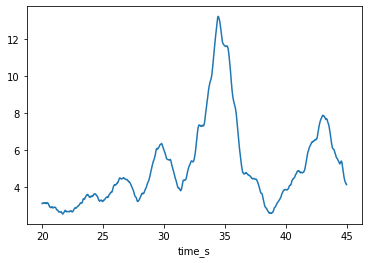

In [277]:
QoM_smooth_segmented_sort_mus[25][3][8].plot() #Sorted stimuli: smooth QoM data for Group 25, Stimuli 3, Participant 8 - you can see that this was the first excerpt

<Axes: xlabel='time_s'>

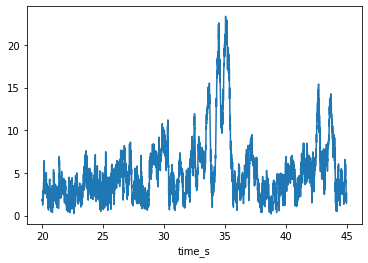

In [278]:
QoM_segmented_sort_mus[25][3][8].plot() #Sorted stimuli: smooth QoM data for Group 25, Stimuli 3, Participant 8 - you can see that this was the first excerpt

Sorted stimuli: smooth QoM data for Group 25, Stimuli 3, Participant 8 - you can see that this silence corresponds to the silence before the first excerpt

In [279]:
QoM_smooth_segmented_sort_sil[25][3][8] #Sorted stimuli: smooth QoM data for Group 25, Stimuli 3, Participant 8 - you can see that this silence corresponds to the silence before the first excerpt

time_s
0.008333     5.171264
0.016667     5.170831
0.025000     5.148778
0.033333     5.127961
0.041667     5.120516
               ...   
19.966667    3.111981
19.975000    3.122976
19.983333    3.121418
19.991667    3.122427
20.000000    3.117583
Name: 8, Length: 2400, dtype: float64

There are gaps in this figure because every breaking wave and hoppipolla have been shortened to allow comparison with other excerpts.

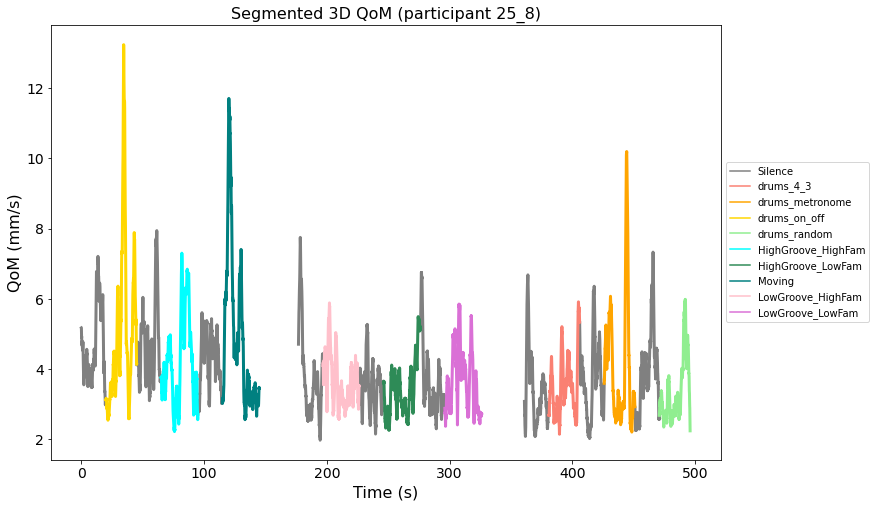

In [280]:
group_num = 25
participant = 8
#Plotting segmented QoM (norm) with color-coded stimuli for one participant

fig8, ax8 = plt.subplots(1)
fig8.set_figheight(8)
fig8.set_figwidth(12)
#ax8.set_facecolor("white")

for i in range(0,9,1):
    ax8.plot(QoM_smooth_segmented_sil[group_num][i][participant], 'gray', lw=3, label='_nolegend_') #plotting silence segments
    
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][1][participant], 'salmon', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][2][participant], 'orange', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][3][participant], 'gold', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][4][participant], 'lightgreen', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][5][participant], 'aqua', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][6][participant], 'seagreen', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][7][participant], 'teal', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][8][participant], 'pink', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus[group_num][9][participant], 'orchid', lw=3, label='_nolegend_') #plotting stimuli


plt.plot([], label="Silence", color='gray')

plt.plot([], label="drums_4_3", color='salmon')
plt.plot([], label="drums_metronome", color='orange')
plt.plot([], label="drums_on_off", color='gold')
plt.plot([], label="drums_random", color='lightgreen')
plt.plot([], label="HighGroove_HighFam", color='aqua')
plt.plot([], label="HighGroove_LowFam", color='seagreen')
plt.plot([], label="Moving", color='teal')
plt.plot([], label="LowGroove_HighFam", color='pink')
plt.plot([], label="LowGroove_LowFam", color='orchid')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Time (s)', fontsize=16);
plt.ylabel('QoM (mm/s)', fontsize=16);
plt.title('Segmented 3D QoM (participant 25_8)', fontsize=16)
#plt.legend(loc='upper right', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

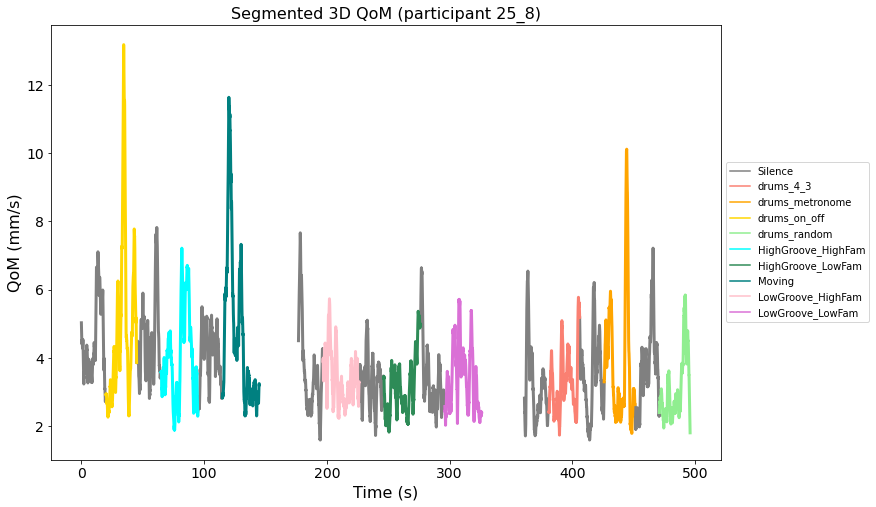

In [281]:
group_num = 25
participant = 8
#Plotting segmented QoM (norm) with color-coded stimuli for one participant

fig8, ax8 = plt.subplots(1)
fig8.set_figheight(8)
fig8.set_figwidth(12)
#ax8.set_facecolor("white")

for i in range(0,9,1):
    ax8.plot(QoM_smooth_segmented_sil_sg[group_num][i][participant], 'gray', lw=3, label='_nolegend_') #plotting silence segments
    
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][1][participant], 'salmon', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][2][participant], 'orange', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][3][participant], 'gold', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][4][participant], 'lightgreen', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][5][participant], 'aqua', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][6][participant], 'seagreen', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][7][participant], 'teal', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][8][participant], 'pink', lw=3, label='_nolegend_') #plotting stimuli
ax8.plot(QoM_smooth_segmented_sort_mus_SG[group_num][9][participant], 'orchid', lw=3, label='_nolegend_') #plotting stimuli


plt.plot([], label="Silence", color='gray')

plt.plot([], label="drums_4_3", color='salmon')
plt.plot([], label="drums_metronome", color='orange')
plt.plot([], label="drums_on_off", color='gold')
plt.plot([], label="drums_random", color='lightgreen')
plt.plot([], label="HighGroove_HighFam", color='aqua')
plt.plot([], label="HighGroove_LowFam", color='seagreen')
plt.plot([], label="Moving", color='teal')
plt.plot([], label="LowGroove_HighFam", color='pink')
plt.plot([], label="LowGroove_LowFam", color='orchid')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Time (s)', fontsize=16);
plt.ylabel('QoM (mm/s)', fontsize=16);
plt.title('Segmented 3D QoM (participant 25_8)', fontsize=16)
#plt.legend(loc='upper right', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Mean QoM for each sorted segment for each participant
#### Music

In [282]:
group_list = []
stim_list = []
pt_list = []
mean_QoM_list = []
mean_QoMx_list = []
mean_QoMy_list = []
mean_QoMz_list = []
for k,v in QoM_segmented_sort_mus.items():
    for stim in range(1,10):
        stim_qom = v[stim]
        for pt in stim_qom.columns:
            group_list.append(k)
            stim_list.append(stim)
            pt_list.append(pt)
            mean_QoM_list.append(QoM_segmented_sort_mus[k][stim][pt].mean())
            mean_QoMx_list.append(QoMX_segmented_sort_mus[k][stim][pt].mean())
            mean_QoMy_list.append(QoMY_segmented_sort_mus[k][stim][pt].mean())
            mean_QoMz_list.append(QoMZ_segmented_sort_mus[k][stim][pt].mean())
mean_QoM = {
    'Group': group_list,
    'Stimuli': stim_list,
    'Participant': pt_list,
    'mQoM_music': mean_QoM_list,
    'mQoMx_music': mean_QoMx_list,
    'mQoMy_music': mean_QoMy_list,
    'mQoMz_music': mean_QoMz_list
}

In [283]:
mqom_music_df = pd.DataFrame.from_dict(mean_QoM)

In [284]:
mqom_music_df.to_csv("mean_qom_xyz_music_df.csv", index = False)

In [285]:
ind_array = [group_list, stim_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Stim', 'Pt'))
Mean_QoM_df = pd.DataFrame(mean_QoM_list, index = ind) # this is sorted 

In [286]:
Mean_QoM_df.to_csv("mean_qom_df.csv")

In [287]:
unstacked_mean_qom_df = Mean_QoM_df.unstack('Stim')
unstacked_mean_qom_df = unstacked_mean_qom_df.rename(columns={0: "Stimulus"})

#### Silence Unsorted (see below for sorted)

In [288]:
group_list = []
sil_list = []
pt_list = []
mean_QoM_list = []
for k,v in QoM_segmented_sil.items():
    for sil in range(0,9):
        sil_qom = v[sil]
        for pt in sil_qom.columns:
            group_list.append(k)
            sil_list.append(sil)
            pt_list.append(pt)
            mean_QoM_list.append(QoM_segmented_sil[k][sil][pt].mean())
mean_QoM = {
    'Group': group_list,
    'Silence': sil_list,
    'Participant': pt_list,
    'mean_QoM': mean_QoM_list
}
ind_array = [group_list, sil_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Silence', 'Pt'))
Mean_QoM_silence_df = pd.DataFrame(mean_QoM_list, index = ind)

In [289]:
unstacked_mean_qom_sil_df = Mean_QoM_silence_df.unstack('Silence')
unstacked_mean_qom_sil_df = unstacked_mean_qom_sil_df.rename(columns={0: "Silence"})

In [290]:
unstacked_mean_qom_sil_df

Silence                        ...                                 
Silence     Silence          1          2  ...          6          7          8
Group Pt                                   ...                                 
1     7    9.532769   7.651455   6.265613  ...   7.379594   7.207741   7.069488
      8    8.862596   6.570777   8.471434  ...   6.725232   7.044013   7.187788
      9    8.199372   9.713602   9.523344  ...   7.656596   9.338561   7.427138
2     4   16.545617  12.139463  13.658009  ...  12.208117  18.561002  17.591756
      5    9.627925   5.464708   5.147028  ...   5.169905   5.464976   4.666848
...             ...        ...        ...  ...        ...        ...        ...
25    9   10.022724   7.824906   6.696626  ...   8.636652   6.869456   8.362321
26    4    8.390224   6.507779   8.356759  ...   7.478036   7.379560   8.176399
      5    7.809581   8.056226   8.562265  ...   8.707312   8.193154   6.391707
      7    7.163147   5.261808   5.584160  ...   6.030883   5.779349   5.107216
      8    5.420949   4.949392   4.841929  ...   4.653125   4.616056   5.413951

[160 rows x 9 columns]

#### Silence: Sorted

In [291]:
group_list = []
sil_list = []
pt_list = []
mean_QoM_list = []
mean_QoMx_list = []
mean_QoMy_list = []
mean_QoMz_list = []
for k,v in QoM_segmented_sort_sil.items():
    for sil in range(1,10):
        sil_qom = v[sil]
        for pt in sil_qom.columns:
            group_list.append(k)
            sil_list.append(sil)
            pt_list.append(pt)
            mean_QoM_list.append(QoM_segmented_sort_sil[k][sil][pt].mean())
            mean_QoMx_list.append(QoMX_segmented_sort_sil[k][sil][pt].mean())
            mean_QoMy_list.append(QoMY_segmented_sort_sil[k][sil][pt].mean())
            mean_QoMz_list.append(QoMZ_segmented_sort_sil[k][sil][pt].mean())
mean_QoM = {
    'Group': group_list,
    'Stimuli': sil_list, # preceding silence
    'Participant': pt_list,
    'mQoM_silence': mean_QoM_list,
    'mQoMx_silence': mean_QoMx_list,
    'mQoMy_silence': mean_QoMy_list,
    'mQoMz_silence': mean_QoMz_list
}

In [292]:
mqom_silence_df = pd.DataFrame.from_dict(mean_QoM)

In [293]:
mqom_silence_df.to_csv("mean_qom_xyz_silence_df.csv", index = False)

In [294]:
mqom_df = pd.merge(mqom_music_df, mqom_silence_df, on = ['Group', 'Participant', 'Stimuli'])

In [295]:
from datetime import date
today = date.today()
print(today)

2024-06-22


In [296]:
mqom_df.to_csv("mean_qom_xyz_df"+str(today)+".csv", index = False) # then import this to R

In [297]:
ind_array = [group_list, sil_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Silence', 'Pt'))
Mean_QoM_silence_sorted_df = pd.DataFrame(mean_QoM_list, index = ind)

In [298]:
Mean_QoM_silence_sorted_df.to_csv("mean_qom_silence_df.csv")

In [299]:
unstacked_mean_qom_sil_sort_df = Mean_QoM_silence_sorted_df.unstack('Silence')
unstacked_mean_qom_sil_sort_df = unstacked_mean_qom_sil_sort_df.rename(columns={0: "Silence"})

In [300]:
# Try concatenating the silence and the music to see if there are any particular silences driving up the average.

In [301]:
music_and_silence = pd.concat([unstacked_mean_qom_df, unstacked_mean_qom_sil_df], axis = 1)

In [ ]:
#Box plot of QoM by Stimulus

figbox, axbox = plt.subplots(figsize=(20,7))
qombox = seaborn.boxplot(ax=axbox, data=music_and_silence, width=0.8)
axbox.set_facecolor("white")
axbox.yaxis.grid(color='gray')
qombox.set_xlabel("Stimulus",fontsize=18)
qombox.set_ylabel("QoM (mm/s)",fontsize=18)
qombox.tick_params(labelsize=14)
plt.ylim(0, 15)

#### This boxplot definitely indicates that at least the first silence has more motion than the remainder of the silent segments and that it should not be included when averaging the QoM of the silent segments.  

In [ ]:
remove_first_sil = unstacked_mean_qom_sil_df.iloc[:,1:9] # because when examining a boxplot comparing the average of all silences, the silence was definitely not appearing lower than the music. 

In [ ]:
mean_qom_silence = remove_first_sil.mean(axis = 'columns')

In [ ]:
unstacked_mean_qom_df.insert(0,'Silence', mean_qom_silence)

In [ ]:
mean_qom_silence = pd.DataFrame({'Silence': remove_first_sil.mean(axis = 'columns')})

In [ ]:
unstacked_mean_qom_df = Mean_QoM_df.unstack('Stim')
unstacked_mean_qom_df = unstacked_mean_qom_df.rename(columns={0: "Stimulus"})

In [ ]:
stim_and_sil = pd.concat([unstacked_mean_qom_df, mean_qom_silence], axis = 1)

In [ ]:
#Box plot of QoM by Stimulus with mean silence

figbox, axbox = plt.subplots(figsize=(20,7))
qombox = seaborn.boxplot(ax=axbox, data=stim_and_sil, width=0.8)
axbox.set_facecolor("white")
axbox.yaxis.grid(color='gray')
qombox.set_xlabel("Stimulus",fontsize=18)
qombox.set_ylabel("QoM (mm/s)",fontsize=18)
qombox.tick_params(labelsize=14)
#plt.ylim(0, 60)
plt.ylim(0, 15)

In [ ]:
stim_and_sil.describe()

In [ ]:
mean_all = stim_and_sil.mean(axis = 'columns')

In [ ]:
mean_all.describe()

### SAVGOL: Mean QoM for each sorted segment for each participant
#### SAVGOL Music

In [ ]:
group_list = []
stim_list = []
pt_list = []
mean_QoM_list_SG = []
mean_QoMx_list_SG = []
mean_QoMy_list_SG = []
mean_QoMz_list_SG = []
for k,v in QoM_segmented_sort_mus_SG.items():
    for stim in range(1,10):
        stim_qom = v[stim]
        for pt in stim_qom.columns:
            group_list.append(k)
            stim_list.append(stim)
            pt_list.append(pt)
            mean_QoM_list_SG.append(QoM_segmented_sort_mus_SG[k][stim][pt].mean())
            mean_QoMx_list_SG.append(QoMX_segmented_sort_mus_SG[k][stim][pt].mean())
            mean_QoMy_list_SG.append(QoMY_segmented_sort_mus_SG[k][stim][pt].mean())
            mean_QoMz_list_SG.append(QoMZ_segmented_sort_mus_SG[k][stim][pt].mean())
mean_QoM_SG = {
    'Group': group_list,
    'Stimuli': stim_list,
    'Participant': pt_list,
    'mQoM_music': mean_QoM_list_SG,
    'mQoMx_music': mean_QoMx_list_SG,
    'mQoMy_music': mean_QoMy_list_SG,
    'mQoMz_music': mean_QoMz_list_SG
}

In [ ]:
mqom_music_df_SG = pd.DataFrame.from_dict(mean_QoM_SG)

In [ ]:
mqom_music_df_SG.to_csv("mean_qom_xyz_music_df_savgol.csv", index = False)

In [ ]:
ind_array = [group_list, stim_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Stim', 'Pt'))
Mean_QoM_df_SG = pd.DataFrame(mean_QoM_list_SG, index = ind) # this is sorted 

In [ ]:
Mean_QoM_df_SG.to_csv("mean_qom_df_savgol.csv")

In [ ]:
unstacked_mean_qom_df_SG = Mean_QoM_df_SG.unstack('Stim')
unstacked_mean_qom_df_SG = unstacked_mean_qom_df_SG.rename(columns={0: "Stimulus"})

#### SAVGOL: Silence Unsorted (see below for sorted)

In [ ]:
group_list = []
sil_list = []
pt_list = []
mean_QoM_list = []
for k,v in QoM_segmented_sil_sg.items():
    for sil in range(0,9):
        sil_qom = v[sil]
        for pt in sil_qom.columns:
            group_list.append(k)
            sil_list.append(sil)
            pt_list.append(pt)
            mean_QoM_list.append(QoM_segmented_sil_sg[k][sil][pt].mean())
mean_QoM = {
    'Group': group_list,
    'Silence': sil_list,
    'Participant': pt_list,
    'mean_QoM': mean_QoM_list
}
ind_array = [group_list, sil_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Silence', 'Pt'))
Mean_QoM_silence_df_SG = pd.DataFrame(mean_QoM_list, index = ind)

In [ ]:
unstacked_mean_qom_sil_df_SG = Mean_QoM_silence_df_SG.unstack('Silence')
unstacked_mean_qom_sil_df_SG = unstacked_mean_qom_sil_df_SG.rename(columns={0: "Silence"})

In [ ]:
unstacked_mean_qom_sil_df_SG

#### SAVGOL Silence: Sorted

In [ ]:
group_list = []
sil_list = []
pt_list = []
mean_QoM_list = []
mean_QoMx_list = []
mean_QoMy_list = []
mean_QoMz_list = []
for k,v in QoM_segmented_sort_sil_SG.items():
    for sil in range(1,10):
        sil_qom = v[sil]
        for pt in sil_qom.columns:
            group_list.append(k)
            sil_list.append(sil)
            pt_list.append(pt)
            mean_QoM_list.append(QoM_segmented_sort_sil_SG[k][sil][pt].mean())
            mean_QoMx_list.append(QoMX_segmented_sort_sil_SG[k][sil][pt].mean())
            mean_QoMy_list.append(QoMY_segmented_sort_sil_SG[k][sil][pt].mean())
            mean_QoMz_list.append(QoMZ_segmented_sort_sil_SG[k][sil][pt].mean())
mean_QoM_SG = {
    'Group': group_list,
    'Stimuli': sil_list, # preceding silence
    'Participant': pt_list,
    'mQoM_silence': mean_QoM_list,
    'mQoMx_silence': mean_QoMx_list,
    'mQoMy_silence': mean_QoMy_list,
    'mQoMz_silence': mean_QoMz_list
}

In [ ]:
mqom_silence_df_SG = pd.DataFrame.from_dict(mean_QoM_SG)

In [ ]:
mqom_silence_df_SG.to_csv("mean_qom_xyz_silence_df_savgol.csv", index = False)

In [ ]:
mqom_df_SG = pd.merge(mqom_music_df_SG, mqom_silence_df_SG, on = ['Group', 'Participant', 'Stimuli'])

In [ ]:
mqom_df_SG.to_csv("mean_qom_xyz_df_savgol.csv", index = False) # then import this to R

In [ ]:
ind_array = [group_list, sil_list, pt_list]
ind = pd.MultiIndex.from_arrays(ind_array, names = ('Group', 'Silence', 'Pt'))
Mean_QoM_silence_sorted_df_SG = pd.DataFrame(mean_QoM_list, index = ind)

In [ ]:
Mean_QoM_silence_sorted_df_SG.to_csv("mean_qom_silence_df_savgol.csv")

## Pickle data for future usage

In [ ]:
os.chdir('C:/Users/Dana/Documents/PhD/Research/Standstill/Motion_Analysis/Python/')

In [ ]:
with open('QoM_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoM_segmented_sort_mus, f)

In [ ]:
with open('QoM_smooth_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoM_smooth_segmented_sort_mus, f)

In [ ]:
with open('QoMX_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoMX_segmented_sort_mus, f)

In [ ]:
with open('QoMX_smooth_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoMX_smooth_segmented_sort_mus, f)

In [ ]:
with open('QoMY_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoMY_segmented_sort_mus, f)

In [ ]:
with open('QoMY_smooth_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoMY_smooth_segmented_sort_mus, f)

In [ ]:
with open('QoMZ_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoMZ_segmented_sort_mus, f)

In [ ]:
with open('QoMZ_smooth_segmented_sort_mus.pkl', 'wb') as f:
    pickle.dump(QoMZ_smooth_segmented_sort_mus, f)

In [ ]:
with open('QoM_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoM_segmented_sort_sil, f)

In [ ]:
with open('QoM_smooth_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoM_smooth_segmented_sort_sil, f)

In [ ]:
with open('QoMX_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoMX_segmented_sort_sil, f)

In [ ]:
with open('QoMX_smooth_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoMX_smooth_segmented_sort_sil, f)

In [ ]:
with open('QoMY_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoMY_segmented_sort_sil, f)

In [ ]:
with open('QoMY_smooth_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoMY_smooth_segmented_sort_sil, f)

In [ ]:
with open('QoMZ_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoMZ_segmented_sort_sil, f)

In [ ]:
with open('QoMZ_smooth_segmented_sort_sil.pkl', 'wb') as f:
    pickle.dump(QoMZ_smooth_segmented_sort_sil, f)

In [ ]:
with open('EC22.pkl', 'wb') as f:
    pickle.dump(ec22, f)

Pickle savgol data for future usage

In [ ]:
with open('QoM_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoM_segmented_sort_mus_SG, f)

In [ ]:
with open('QoM_smooth_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoM_smooth_segmented_sort_mus_SG, f)

In [ ]:
with open('QoMX_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoMX_segmented_sort_mus_SG, f)

In [ ]:
with open('QoMX_smooth_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoMX_smooth_segmented_sort_mus_SG, f)

In [ ]:
with open('QoMY_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoMY_segmented_sort_mus_SG, f)

In [ ]:
with open('QoMY_smooth_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoMY_smooth_segmented_sort_mus_SG, f)

In [ ]:
with open('QoMZ_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoMZ_segmented_sort_mus_SG, f)

In [ ]:
with open('QoMZ_smooth_segmented_sort_mus_SG.pkl', 'wb') as f:
    pickle.dump(QoMZ_smooth_segmented_sort_mus_SG, f)

In [ ]:
with open('QoM_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoM_segmented_sort_sil_SG, f)

In [ ]:
with open('QoM_smooth_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoM_smooth_segmented_sort_sil_SG, f)

In [ ]:
with open('QoMX_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoMX_segmented_sort_sil_SG, f)

In [ ]:
with open('QoMX_smooth_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoMX_smooth_segmented_sort_sil_SG, f)

In [ ]:
with open('QoMY_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoMY_segmented_sort_sil_SG, f)

In [ ]:
with open('QoMY_smooth_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoMY_smooth_segmented_sort_sil_SG, f)

In [ ]:
with open('QoMZ_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoMZ_segmented_sort_sil_SG, f)

In [ ]:
with open('QoMZ_smooth_segmented_sort_sil_SG.pkl', 'wb') as f:
    pickle.dump(QoMZ_smooth_segmented_sort_sil_SG, f)